# **Optimize Performance in BigQuery**
Author: Philip Chopovsky (philipchop@google.com)

---

**Goal:** gain hands on expirience on **data modeling, monitoring and query optimization**. By the end of this notebook, you will not just know that a query is slow, you will know how to model your data and read the Execution Graph to identify bottlenecks and possible optimizations.

**Notebook Flow:**
* Physical Data Modeling:

   * The Baseline: Apply Partitioning & Clustering to drastically reduce bytes scanned.

  * Advanced Features: Implement Materialized Views for auto-refreshed aggregations and BI Engine for sub-second in-memory latency.

  * Advanced Storage: Use Search Indexes for text, Primary/Foreign Keys for join elimination, and Nested Fields for denormalization.

* Analyze BigQuery Performance:

  * Simulate Chaos: We generate a "Chaos Table" with intentional skew, heavy payloads, and CPU-intensive strings.

  * The Diagnosis: Use the Execution Graph to "read the MRI" of the Query Plan. We will identify specific bottlenecks like Partition Skew, Shuffle Quota exhaustion, Slot Contention, and High Cardinality Joins.

* Query Optimizations:

  * Run "Bad" vs. "Good" SQL patterns side-by-side to quantify the impact on Slot Time and Duration.

  * Key Patterns: SELECT *, COUNT(DISTINCT), ORDER BY, WHERE clause ordering, INT64 vs. STRING joins, JSON parsing, RegExp vs. LIKE, and Pre-aggregation strategies.

The Hierarchy
Here is how BigQuery actually breaks it down:

Query Plan (The Job): The entire SQL request.

Node / Stage: The query is broken into sequential steps (Scan, Join, Aggregate).

Example: "Stage 1: Read Table A."

Task: BigQuery slices the data for that Stage into small pieces.

Example: If Table A is 100GB, BigQuery breaks Stage 1 into 1,000 "Read Tasks."

Slot: The available workers pick up these Tasks.

If you have 500 Slots, they will pick up 500 tasks, finish them, and then come back for the remaining 500.

# ************************************************************
# **IMPORTANT BEFORE RUNNING THE NOTEBOOK:** You are about to run a heavy notebook which, which will imply costs on your environment.
# Consider to study from the pre-run results and copy only the parts you need for your environment.
# **********************************************************

## **0. Prerequisites & Setup**


Setup Environment

In [ ]:
"""
Initializes the BigQuery client and sets up the working dataset.

1.  **Initialize Client**: Connects to the specified project and region.
    *   `use_query_cache=False`: Disables caching to ensure every query runs fully for demonstration.
2.  **Create Working Dataset**: checks if `bq_diagnostic_lab` exists, and creates it if not.

Parameters:
*   `PROJECT_ID`: Your Google Cloud Project ID.
*   `REGION`: Region to process data (e.g., 'US', 'EU').
*   `WORKING_DATASET_ID`: Name of the dataset for this lab.
"""
# @markdown Enter your Project ID and a name for your working dataset.
PROJECT_ID = "" # @param {type:"string"}
REGION = "US" # @param {type:"string"}
WORKING_DATASET_ID = "bq_diagnostic_lab" # @param {type:"string"}
# @markdown Enter your data location for the simulation
BASELINE_PROJECT_ID = "bigquery-public-data"# @param {type:"string"}
BASELINE_DATASET_ID = "wikipedia"# @param {type:"string"}
BASELINE_TABLE_ID = "pageviews_2024"# @param {type:"string"}
CHAOS_FACTOR = 1 # @param {type:"integer"}
ON_DEMAND_PRICE = 6.25 # @param {type:"number"}

import sys
import time
import humanize
from google.cloud import bigquery
from google.api_core.exceptions import NotFound, Forbidden


# 1. Initialize Client
try:
    client = bigquery.Client(project=PROJECT_ID, location=REGION)
    job_config = bigquery.QueryJobConfig(use_query_cache=False)
    client.default_query_job_config = job_config
    print(f"Authenticated to project: {PROJECT_ID}")
    print(f"Query caching turned off. Make sure to run the cleanup script or enable it manually")
except Exception as e:
    print(f"Error: {e}")
    print("Please make sure you are authenticated (Run: gcloud auth application-default login)")

# 2. Create Working Dataset
dataset_id = f"{PROJECT_ID}.{WORKING_DATASET_ID}"
dataset = bigquery.Dataset(dataset_id)
dataset.location = REGION

try:
    client.create_dataset(dataset, timeout=30)
    print(f"Created dataset {dataset_id}")
except Exception as e:
    if "Already Exists" in str(e):
         print(f"Dataset {dataset_id} already exists.")
    else:
         print(f"Error creating dataset: {e}")

Authenticated to project: van-der-linde-1899
Query caching turned off. Make sure to run the cleanup script or enable it manually
Dataset van-der-linde-1899.bq_diagnostic_lab already exists.


Helper Functions

In [ ]:
"""
Utility functions for comparing BigQuery jobs and estimating costs.
"""

def estimate_cost(bytes_processed):
    """Converts bytes processed to On-Demand cost ($6.25/TB)."""
    if bytes_processed is None: return 0.0
    tb = bytes_processed / 10**12
    return tb * ON_DEMAND_PRICE

def compare_bq_jobs(*args, **kwargs):
    """
    Prints a side-by-side comparison of multiple jobs.
    Supports both positional args (auto-named) and keyword args (custom named).

    Usage:
      compare_bq_jobs(job1, job2) -> Columns: "Baseline", "Job 2"
      compare_bq_jobs(Baseline=job1, Clustered=job2) -> Columns: "Baseline", "Clustered"
    """

    # 1. Consolidate all jobs into a list of (Name, Job) tuples
    job_list = []

    # Handle positional arguments (legacy support)
    for i, job in enumerate(args):
        name = f"Job {i+1}" if i > 0 else "Baseline"
        job_list.append((name, job))

    # Handle keyword arguments (custom names)
    for name, job in kwargs.items():
        job_list.append((name, job))

    if not job_list:
        print("No jobs provided to compare.")
        return

    # 2. Collect Stats
    all_stats = []
    for name, job in job_list:
        if not job: continue

        duration = (job.ended - job.started).total_seconds() if job.ended and job.started else 0
        total_shuffle = 0
        if job.query_plan:
            for stage in job.query_plan:
                if stage.shuffle_output_bytes:
                    total_shuffle += stage.shuffle_output_bytes
        stats = {
            "name": name,
            "id": job.job_id,
            "time": duration,
            "bytes": job.total_bytes_processed or 0,
            "shuffle": total_shuffle,
            "cost": estimate_cost(job.total_bytes_processed),
            "slots": job.slot_millis or 0
        }
        all_stats.append(stats)

    if not all_stats: return

    # 3. Define Metrics
    metrics = [
        ("Duration", "time", "{:.2f}s"),
        ("Slot Time", "slots", lambda x: humanize.precisedelta(x/1000, minimum_unit="seconds", format="%0.2f")),
        ("Bytes Scanned", "bytes", lambda x: humanize.naturalsize(x)),
        ("Bytes Shuffled", "shuffle", lambda x: humanize.naturalsize(x)),
        ("Est. Cost", "cost", "${:.4f}")
    ]

    # 4. Build Table Headers
    col_width_metric = 20
    col_width_val = 20
    col_width_impact = 10

    # Header Row
    header = f"{'METRIC':<{col_width_metric}} | {all_stats[0]['name']:<{col_width_val}}"
    for stat in all_stats[1:]:
        header += f" | {stat['name']:<{col_width_val}} {'(Impact)':<{col_width_impact}}"

    print("-" * len(header))
    print(header)
    print("-" * len(header))

    # Helper for diff calculation
    def fmt_diff(v1, v2):
        if v1 == 0: return "N/A"
        diff = (v2 - v1) / v1
        return f"{diff:+.1%}"

    # 5. Print Data Rows
    base_stats = all_stats[0]
    for label, key, fmt in metrics:
        # Baseline Column
        val_base = base_stats[key]
        val_base_str = fmt(val_base) if callable(fmt) else fmt.format(val_base)
        row = f"{label:<{col_width_metric}} | {val_base_str:<{col_width_val}}"

        # Comparison Columns
        for stat in all_stats[1:]:
            val_curr = stat[key]
            val_curr_str = fmt(val_curr) if callable(fmt) else fmt.format(val_curr)
            diff_str = fmt_diff(val_base, stat[key])
            row += f" | {val_curr_str:<{col_width_val}} {diff_str:<{col_width_impact}}"
        print(row)
    print("-" * len(header))


---
## **1. Physical Data Modeling**



In [ ]:
"""
Create the Baseline (Naive) Table.

We are copying a subset (until 2024-12-31) of the public Wikipedia pageviews dataset.
This table `pageviews_basic` has **NO** Partitioning or Clustering applied.
It serves as our performance baseline to demonstrate the cost of a full table scan.
"""
copy_data = f"{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_basic"

query = f"""
CREATE TABLE IF NOT EXISTS `{copy_data}`
AS
SELECT *
FROM
  `{BASELINE_PROJECT_ID}.{BASELINE_DATASET_ID}.{BASELINE_TABLE_ID}`
WHERE DATE(datehour) <= '2024-12-31';
"""

print(f"Creating Basic Table")
job_create_opt = client.query(query)
job_create_opt.result()
print("Basic Table Created!")

Creating Basic Table
Basic Table Created!


### **→** Run the Naive Query
We will ask for **Total Views for 'Google' on Jan 1st**.
Because the table is flat, BQ must scan all 50 days to find that one record.

In [ ]:
"""
Execute the Naive Query.

We search for a specific record ('Google' on '2024-01-01').
Because the table `pageviews_basic` is not partitioned, BigQuery performs a **FULL TABLE SCAN**.
It reads every single byte in the table to find the matching rows.
"""
query_naive = f"""
SELECT
    title,
    SUM(views) as total_views
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_basic`
WHERE DATE(datehour) = '2024-01-01'
AND title = 'Google'
GROUP BY 1
"""

print("Running Naive Query (Full Table Scan)")
job_naive = client.query(query_naive)
res = job_naive.result()

Running Naive Query (Full Table Scan)


### **→** Clustering and Partitioning




**The Problem:** When you run a query against a standard (flat) table, BigQuery performs **a Full Table Scan**. It reads every single row and column in the table, even if you only need data from a specific date or category. This leads to high costs (bytes scanned) and slower performance.

**The Solution:**
* **Partitioning** divides your table into physical segments (e.g., by Day). If you query `WHERE date = '2024-01-01'`, BigQuery only scans that specific partition, ignoring the rest.
* **Clustering** sorts the data within each partition based on a column (e.g., title). This allows BigQuery to skip data blocks that don't match your filter (Block Pruning).

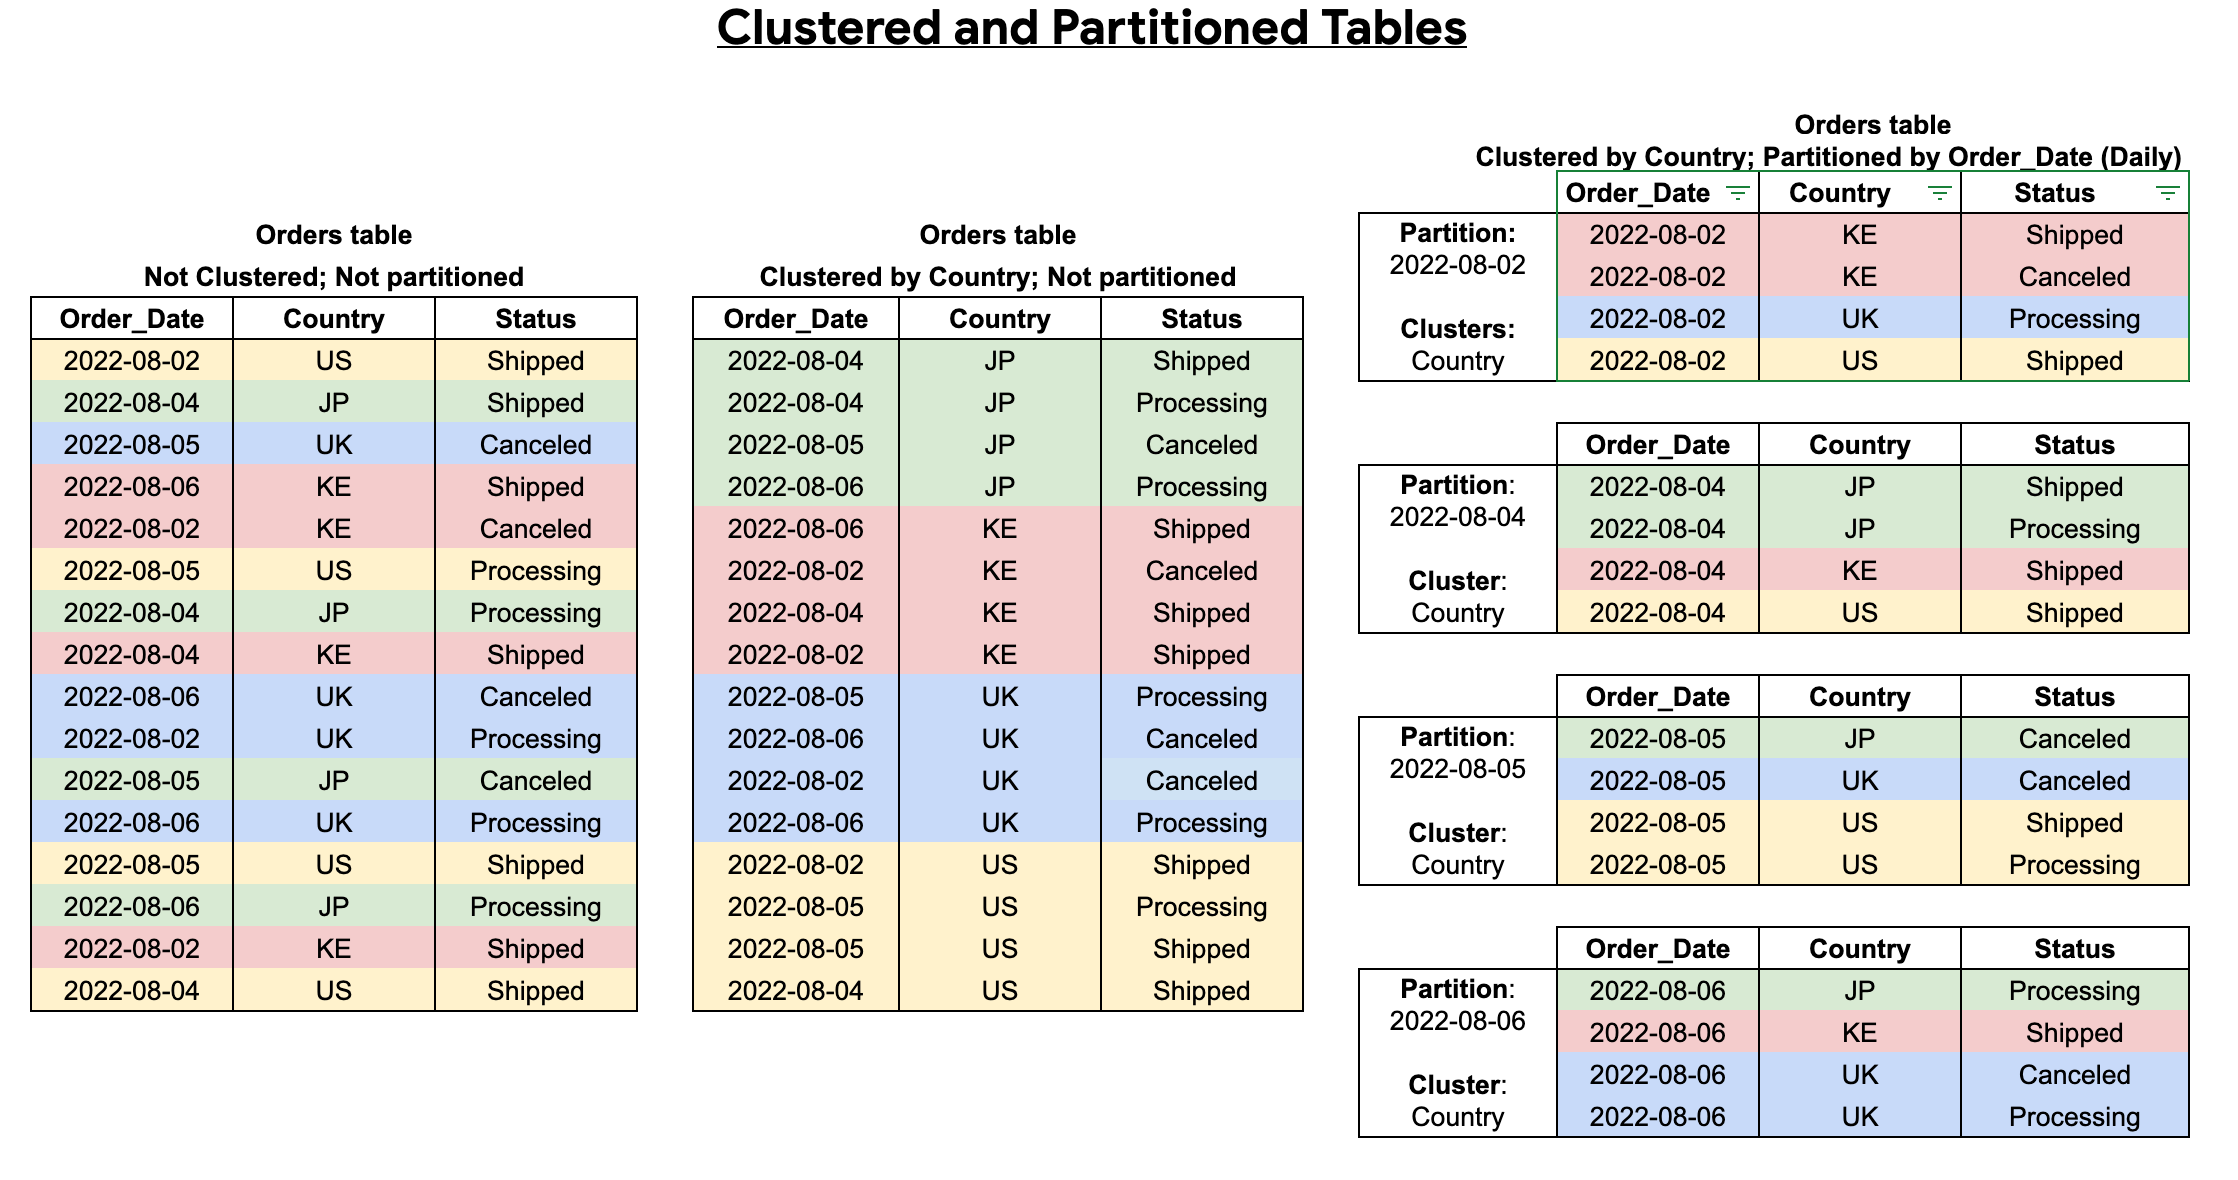

Setup Tables



In [ ]:
"""
Create the Baseline (Naive) Table.

We are copying a subset (until 2024-12-31) of the public Wikipedia pageviews dataset.
This table `pageviews_basic` has **NO** Partitioning or Clustering applied.
It serves as our performance baseline to demonstrate the cost of a full table scan.
"""
table_clustered = f"{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_clustered"

query = f"""
CREATE TABLE IF NOT EXISTS `{table_clustered}`
CLUSTER BY title
AS
SELECT *
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_basic`
WHERE DATE(datehour) <= '2024-12-31'
"""

print(f"Creating Clustered Table")
job_create_opt = client.query(query)
job_create_opt.result()
print("Clustered Table Created!")

Creating Clustered Table
Clustered Table Created!


In [ ]:
"""
Create the Baseline (Naive) Table.

We are copying a subset (until 2024-12-31) of the public Wikipedia pageviews dataset.
This table `pageviews_basic` has **NO** Partitioning or Clustering applied.
It serves as our performance baseline to demonstrate the cost of a full table scan.
"""
table_partitioned = f"{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_partitioned"

query = f"""
CREATE TABLE IF NOT EXISTS `{table_partitioned}`
PARTITION BY DATE(datehour)
AS
SELECT * FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_basic`
WHERE DATE(datehour) <= '2024-12-31'
"""

print(f"Creating Partitioned Table")
job_create_opt = client.query(query)
job_create_opt.result()
print("Partitioned Table Created!")

Creating Partitioned Table
Partitioned Table Created!


In [ ]:
"""
Create the Baseline (Naive) Table.

We are copying a subset (until 2024-12-31) of the public Wikipedia pageviews dataset.
This table `pageviews_basic` has **NO** Partitioning or Clustering applied.
It serves as our performance baseline to demonstrate the cost of a full table scan.
"""
table_clustered_partitioned = f"{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_clustered_partitioned"

query = f"""
CREATE TABLE IF NOT EXISTS `{table_clustered_partitioned}`
PARTITION BY DATE(datehour)
CLUSTER BY title
AS
SELECT * FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_basic`
WHERE DATE(datehour) <= '2024-12-31'
"""

print(f"Creating Partitioned & Clustered Table")
job_create_opt = client.query(query)
job_create_opt.result()
print("Partitioned & Clustered Table Created!")

Creating Partitioned & Clustered Table
Partitioned & Clustered Table Created!


Run the Optimized Queries

In [ ]:
query_clustered = f"""
SELECT
    title,
    SUM(views) as total_views
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_clustered`
WHERE DATE(datehour) = '2024-01-01'
AND title = 'Google'
GROUP BY 1
"""

print("Running Optimized Query...")
job_opt_clustered = client.query(query_clustered)
job_opt_clustered.result()

Running Optimized Query...


In [ ]:
query_partitioned = f"""
SELECT
    title,
    SUM(views) as total_views
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_partitioned`
WHERE DATE(datehour) = '2024-01-01'
AND title = 'Google'
GROUP BY 1
"""

print("Running Optimized Query...")
job_opt_partitioned = client.query(query_partitioned)
job_opt_partitioned.result()

Running Optimized Query...


In [ ]:
query_clustered_partitioned = f"""
SELECT
    title,
    SUM(views) as total_views
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_clustered_partitioned`
WHERE DATE(datehour) = '2024-01-01'
AND title = 'Google'
GROUP BY 1
"""

print("Running Optimized Query...")
job_opt_clustered_partitioned = client.query(query_clustered_partitioned)
job_opt_clustered_partitioned.result()

Running Optimized Query...


In [ ]:
compare_bq_jobs(job_naive=job_naive, job_opt_clustered=job_opt_clustered, job_opt_partitioned=job_opt_partitioned, job_opt_clustered_partitioned=job_opt_clustered_partitioned)

----------------------------------------------------------------------------------------------------------------------------------------------------------
METRIC               | job_naive            | job_opt_clustered    (Impact)   | job_opt_partitioned  (Impact)   | job_opt_clustered_partitioned (Impact)  
----------------------------------------------------------------------------------------------------------------------------------------------------------
Duration             | 9.92s                | 0.44s                -95.6%     | 5.54s                -44.2%     | 0.83s                -91.6%    
Slot Time            | 5 hours, 58 minutes and 12.76 seconds | 0.16 seconds         -100.0%    | 2 minutes and 17.09 seconds -99.4%     | 0.50 seconds         -100.0%   
Bytes Scanned        | 2.3 TB               | 101.9 MB             -100.0%    | 5.6 GB               -99.8%     | 100.2 MB             -100.0%   
Bytes Shuffled       | 97.6 kB              | 19 Bytes             -100.0

**Key Takeaways:**

* Benchmark different combination of Partitioning and Clustering in order to find what works best for your workloads. Partitioning works best for low-cardinality filters (Date, Region), while Clustering works best for high-cardinality filters (User ID, Title).

* Cost Reduction: Dramatically reduces Bytes Scanned.

**Links to Documentation:**


* Introduction to partitioned tables: https://docs.cloud.google.com/bigquery/docs/partitioned-tables
* Creating partitioned tables: https://docs.cloud.google.com/bigquery/docs/creating-partitioned-tables
* Introduction to clustered tables: https://docs.cloud.google.com/bigquery/docs/clustered-tables
* Create clustered tables: https://docs.cloud.google.com/bigquery/docs/creating-clustered-tables

### **→** Materialized Views
**The Problem:** Analytical dashboards often run the exact same heavy aggregation queries repeatedly (e.g., "Total Sales by Month"). BigQuery has to re-calculate these aggregations from raw data every time the dashboard refreshes, wasting compute resources and time.

**The Solution:** **Materialized Views (MVs)**.
Unlike a standard logical View (which is just a saved query that runs every time), an MV **pre-computes and caches** the result in intervals defined by the user.

In [ ]:
"""
Execute the Naive Query.

We search for a specific record ('Google' on '2024-01-01').
Because the table `pageviews_basic` is not partitioned, BigQuery performs a **FULL TABLE SCAN**.
It reads every single byte in the table to find the matching rows.
"""
query_agg = f"""
SELECT
    title,
    DATE_TRUNC(DATE(datehour), MONTH) as month,
    SUM(views) as total_views,
    COUNT(*) as records
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_basic`
WHERE title = 'Google'
GROUP BY 1, 2
"""

print("Running Heavy Aggregation (Without MV)")
job_agg_base = client.query(query_agg)
job_agg_base.result()

Running Heavy Aggregation (Without MV)


In [ ]:
"""
Create a Materialized View (MV).

MVs pre-compute and store the results of a query. They are automatically refreshed by BigQuery.
Here, we aggregate views by Month and Title. This collapses billions of raw rows into a much smaller, pre-aggregated dataset.
"""
mv_id = f"{PROJECT_ID}.{WORKING_DATASET_ID}.mv_monthly_views"

create_mv_sql = f"""
CREATE MATERIALIZED VIEW IF NOT EXISTS `{mv_id}`
AS
SELECT
    title,
    DATE_TRUNC(DATE(datehour), MONTH) as month,
    SUM(views) as total_views,
    COUNT(*) as records
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_basic`
GROUP BY 1, 2
"""

print(f"Creating Materialized View")
try:
    client.query(create_mv_sql).result()
    print("Materialized View Created.")
except Exception as e:
    print(f"Error creating MV (If it exists, that's fine): {e}")

Creating Materialized View
Materialized View Created.


In [ ]:
"""
Query the Materialized View.

We query the MV directly. BigQuery reads the pre-computed results instead of scanning the huge base table.
This drastically reduces `Bytes Scanned` and `Duration`.
"""
query_agg_mv = f"""
SELECT
*
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.mv_monthly_views`
WHERE title = 'Google'
"""

print("Running Heavy Aggregation (With MV existing)...")
job_agg_mv = client.query(query_agg_mv)
job_agg_mv.result()

compare_bq_jobs(job_agg_base=job_agg_base, job_agg_mv=job_agg_mv)

Running Heavy Aggregation (With MV existing)...
-----------------------------------------------------------------------------
METRIC               | job_agg_base         | job_agg_mv           (Impact)  
-----------------------------------------------------------------------------
Duration             | 1.79s                | 1.35s                -24.8%    
Slot Time            | 26 minutes and 17.41 seconds | 32 minutes and 2.07 seconds +21.8%    
Bytes Scanned        | 121.1 GB             | 121.1 GB             +0.0%     
Bytes Shuffled       | 372 Bytes            | 372 Bytes            +0.0%     
Est. Cost            | $0.7570              | $0.7570              +0.0%     
-----------------------------------------------------------------------------


**Key Takeaway:**  
* MVs are excellent for **Dashboard Acceleration**. They allow you to maintain a "Single Source of Truth" (the raw table) in your BI tool, while BigQuery optimizes the cost in the background.

* **Zero Maintenance:** MVs stay in sync with the base table automatically.

* **Smart Tuning:** You don't always need to query the MV directly; BigQuery Optimizer uses it automatically if applicable.

* Partitioning and Clustering are available also in Materialized Views


**Links to Documentation:**


* Introduction to materialized views: https://docs.cloud.google.com/bigquery/docs/materialized-views-intro
* Create materialized views: https://docs.cloud.google.com/bigquery/docs/materialized-views-create



### **→** BI Engine
**The Problem:** Even with optimized tables, there is a latency overhead when reading data from disk (storage). For interactive dashboards requiring sub-second response times, disk I/O is a bottleneck.

**The Solution:** BI Engine is an in-memory analysis service. It keeps active tables (or Materialized Views) in RAM. This bypasses the storage layer entirely, allowing for sub-second query responses and high concurrency without traditional slot usage.

Enable BI Engine

In [ ]:
"""
Enable BI Engine.

We create a BI Engine Reservation of 1 GB.
We explicitly set our Materialized View (`mv_monthly_views`) as a `preferred_table` to ensure it gets loaded into RAM.
"""
mv_table_ref = f"{PROJECT_ID}.{WORKING_DATASET_ID}.mv_monthly_views"

bi_capacity_sql = f"""
ALTER BI_CAPACITY `{PROJECT_ID}.region-{REGION}.default`
SET OPTIONS (
  size_gb = 1,
  preferred_tables = ['{mv_table_ref}']
)
"""

print(f"Creating 1GB BI Engine Reservation in {REGION} via SQL...")
print(f"Targeting Preferred Table: {mv_table_ref}")

try:
    client.query(bi_capacity_sql).result()
    print("BI Engine Enabled & Tuned.")
except Exception as e:
    print(f"Could not enable BI Engine (Permissions/Billing issue): {e}")

Creating 1GB BI Engine Reservation in US via SQL...
Targeting Preferred Table: van-der-linde-1899.bq_diagnostic_lab.mv_monthly_views
BI Engine Enabled & Tuned.


In [ ]:
"""
Run Query with BI Engine.

The subsequent runs of the query should be served entirely from BI Engine's memory.
This typically results in sub-second duration and **zero** slot time usage (as it bypasses the standard execution slots).
"""
client.query(query_agg).result()

query_bi_engine = client.query(query_agg)
query_bi_engine.result()

compare_bq_jobs(job_agg_base=job_agg_base,job_agg_mv=job_agg_mv, query_bi_engine=query_bi_engine)

---------------------------------------------------------------------------------------------------------------
METRIC               | job_agg_base         | job_agg_mv           (Impact)   | query_bi_engine      (Impact)  
---------------------------------------------------------------------------------------------------------------
Duration             | 1.79s                | 1.49s                -16.8%     | 0.85s                -52.6%    
Slot Time            | 26 minutes and 17.41 seconds | 25 minutes and 2.04 seconds -4.8%      | 10 minutes and 45.97 seconds -59.0%    
Bytes Scanned        | 121.1 GB             | 121.1 GB             +0.0%      | 121.1 GB             +0.0%     
Bytes Shuffled       | 372 Bytes            | 372 Bytes            +0.0%      | 372 Bytes            +0.0%     
Est. Cost            | $0.7570              | $0.7570              +0.0%      | $0.7570              +0.0%     
---------------------------------------------------------------------------------

**Key Takeaways:**

* **Sub-second Latency:** Ideal for "Hot" data used in dashboards.

* **Cost Efficiency:** Queries served from BI Engine memory effectively cost $0 in the. on demand plan and the first stage (Input) is not part of the reserved slots.

**Links to Documentation:**


* Introduction to BI Engine: https://docs.cloud.google.com/bigquery/docs/bi-engine-intro
* Reserve BI Engine capacity: https://docs.cloud.google.com/bigquery/docs/bi-engine-reserve-capacity



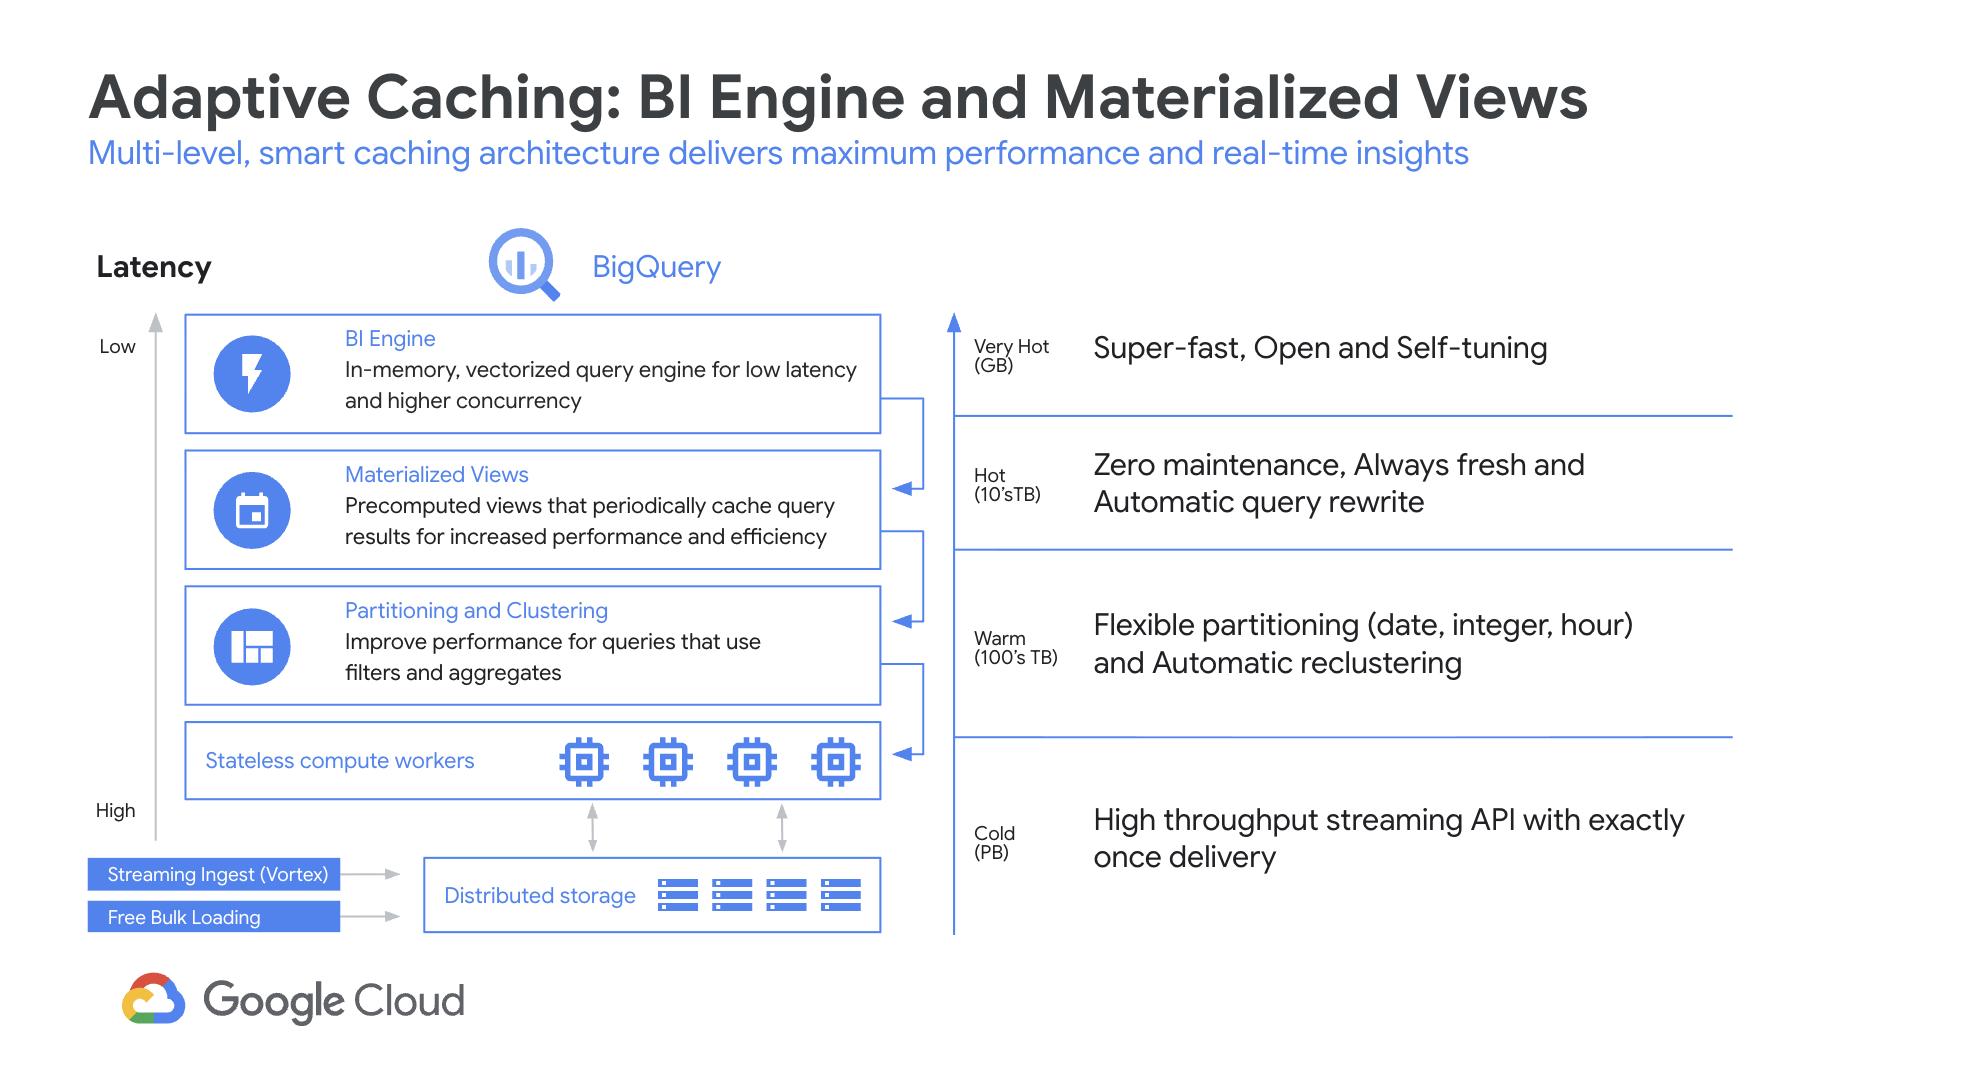

### **→** Nested & Repeated Fields (Denormalization)
**The Problem:** In traditional database design (Normalization), data is split into separate tables (e.g., Orders and Order_Items) to save space. However, in a distributed system like BigQuery, this creates two major performance killers:

* Joins are Expensive: Joining tables requires massive "communication bandwidth" (Shuffle) to move matching rows to the same worker node.

* Flat Denormalization is Wasteful: If you try to fix this by flattening everything into one huge table (one row per line item), you end up duplicating the header data (e.g., repeating the Customer Name for every single item they bought). To analyze this, you are forced to `GROUP BY` later, which triggers another expensive shuffle.

**The Solution:** Instead of forcing data to be either "totally flat" or "totally separate," use Nested (`STRUCT`) and Repeated (`ARRAY`) fields to keep related data together in a single row.
* `STRUCT`: Keeps related fields together (like Item_Name and Item_Price).

* `ARRAY`: Keeps same data type together (like Ordered_Items). Also allows you to put multiple Structs into a single row.

In [ ]:
tbl_nested = f"{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_nested"

sql_create_nested = f"""
CREATE OR REPLACE TABLE `{tbl_nested}`
PARTITION BY DATE(datehour)
CLUSTER BY wiki
AS
SELECT
    datehour,
    wiki,
    -- The Magic: Pack multiple columns into a single object (STRUCT)
    -- and put them in a list (ARRAY_AGG)
    ARRAY_AGG(STRUCT(title, views)) as pages,
    SUM(views) as total_wiki_views_hour
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_partitioned`
WHERE DATE(datehour) = '2024-01-01'
GROUP BY 1, 2
"""

print(f"Creating Nested Table")
job_nested = client.query(sql_create_nested)
job_nested.result()
print("Nested Table Created.")

Creating Nested Table
Nested Table Created.


In [ ]:
"""
Query the Nested Table.

We UNNEST the `wiki` array to filter for specific languages.
This is efficient because we only read the relevant column data and the pre-grouped structure avoids expensive shuffles.
"""
query_flat = f"""
SELECT
    title,
    views
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_partitioned`
WHERE DATE(datehour) = '2024-01-01'
AND wiki = 'en.m'
ORDER BY views DESC
LIMIT 10
"""

query_nested = f"""
SELECT
    p.title,
    p.views
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_nested`,
UNNEST(pages) as p
WHERE DATE(datehour) = '2024-01-01'
AND wiki = 'en.m'
ORDER BY p.views DESC
LIMIT 10
"""

print("Running Flat Query...")
query_flat = client.query(query_flat)
query_flat.result()

print("Running Nested Query...")
query_nested = client.query(query_nested)
query_nested.result()

compare_bq_jobs(query_flat=query_flat, query_nested=query_nested)

Running Flat Query...
Running Nested Query...
-----------------------------------------------------------------------------
METRIC               | query_flat           | query_nested         (Impact)  
-----------------------------------------------------------------------------
Duration             | 1.40s                | 7.06s                +403.4%   
Slot Time            | 31.50 seconds        | 43.20 seconds        +37.1%    
Bytes Scanned        | 6.4 GB               | 917.2 MB             -85.7%    
Bytes Shuffled       | 5.6 kB               | 2.1 kB               -62.2%    
Est. Cost            | $0.0400              | $0.0057              -85.7%    
-----------------------------------------------------------------------------


**Key Takeaways:**

* Faster Execution: Joins require data coordination (communication bandwidth). Denormalization localizes the data to individual slots, so that execution can be done in **parallel**.

* Storage vs. Speed Trade-off: While storing data this way might take slightly more space than a purely normalized 3rd-normal-form database, the massive reduction in query time (CPU/Time) is the priority in BigQuery.

* You preserve the One-to-Many relationship (1 Order to Many Items) without needing a join. The relationship is "pre-joined" in the storage itself.

* In some circumstances, denormalizing your data and using nested and repeated fields doesn't result in increased performance.

**Links to Documentation:**

* Use nested and repeated fields: https://docs.cloud.google.com/bigquery/docs/best-practices-performance-nested
* Specify nested and repeated columns in table schemas: https://docs.cloud.google.com/bigquery/docs/nested-repeated

### **→** Search Index
**The Problem:** Finding a specific string (needle in a haystack) inside a massive unstructured text column is slow. Standard `WHERE col LIKE '%term%'` requires scanning the entire column content, which is computationally expensive and slow.

**The Solution:** Search Index creates an inverted index (similar to Google Search) on the text column. This maps unique tokens to specific rows, allowing BigQuery to "look up" the row location instantly without scanning the actual text data.

In [ ]:
"""
Create a Search Index.

We create a search index on the `title` column.
BigQuery's search index is an inverted index that allows for ultra-fast term lookups, similar to a search engine.
"""
create_index_sql = f"""
CREATE SEARCH INDEX IF NOT EXISTS title_index
ON `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_basic`(title)
"""

print("Creating Search Index on 'title'")
try:
    client.query(create_index_sql).result()
    print("Search Index creation initiated.")
except Exception as e:
    print(f"Error creating index: {e}")

Creating Search Index on 'title'
Search Index creation initiated.


In [ ]:
"""
Run SEARCH() Query.

We use the `SEARCH()` function (or `WHERE ...`) which leverages the underlying index.
This allows BigQuery to skip scanning the entire column and jump directly to the rows containing 'Google'.
"""
query_full_scan = f"""
SELECT *
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_basic`
WHERE title LIKE '%Google%'
"""

query_search_index = f"""
SELECT *
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_basic`
WHERE SEARCH(title, 'Google')
"""

print("Running Standard Scan Query Search")
query_full_scan = client.query(query_full_scan)
query_full_scan.result()

print("Running Search Index Query")
query_search_index = client.query(query_search_index)
query_search_index.result()

compare_bq_jobs(query_full_scan=query_full_scan, query_search_index=query_search_index)

Running Standard Scan Query Search
Running Search Index Query
-----------------------------------------------------------------------------
METRIC               | query_full_scan      | query_search_index   (Impact)  
-----------------------------------------------------------------------------
Duration             | 33.81s               | 19.18s               -43.3%    
Slot Time            | 12 hours, 13 minutes and 53.55 seconds | 10 hours, 17 minutes and 25.23 seconds -15.9%    
Bytes Scanned        | 2.7 TB               | 2.7 TB               +0.0%     
Bytes Shuffled       | 4.5 GB               | 4.4 GB               -1.7%     
Est. Cost            | $16.5948             | $16.5956             +0.0%     
-----------------------------------------------------------------------------


**Key Takeaways:**

* Use Case: Best for log analytics (finding error codes) or unstructured text search.

* Performance: Can drastically reduce slot time for point-lookups in text.

**Links to Documentation:**

* Search indexed data: https://docs.cloud.google.com/bigquery/docs/search



### **→** Primary and Foreign Keys
**The Problem:** We can provide BigQuery with data relationships in our data lake, so when performing joins (e.g., Fact to Dimension), the optimizer won't assume a "Many-to-Many" relationship might exist, which will force BigQuery to read and shuffle data it doesn't actually need.

**The Solution:** Define **Primary Keys (PK)** and **Foreign Keys (FK)** constraints. Even if set to `NOT ENFORCED`, they inform the optimizer about the data structure (e.g., "This ID is unique"). This enables Join Elimination: if you join a table but don't select columns from it, and the PK/FK guarantees a match, the optimizer removes the join entirely.

In [ ]:
"""
Define Primary and Foreign Keys.

We create two tables: `orders` and `order_items`.
We define `order_id` as a Primary Key on `orders` and as a Foreign Key on `order_items`.
This constraint informs the optimizer about the data relationship.
"""
# Set 1: No Keys
tbl_fact_no_keys = f"{PROJECT_ID}.{WORKING_DATASET_ID}.fact_pageviews_no_keys"
tbl_dim_no_keys = f"{PROJECT_ID}.{WORKING_DATASET_ID}.dim_wiki_no_keys"

# Set 2: With Primary and Foreign Keys
tbl_fact_fk = f"{PROJECT_ID}.{WORKING_DATASET_ID}.fact_pageviews_fk"
tbl_dim_pk = f"{PROJECT_ID}.{WORKING_DATASET_ID}.dim_wiki_pk"

query_dim = f"""
CREATE TABLE IF NOT EXISTS`{tbl_dim_no_keys}` AS
SELECT DISTINCT wiki
FROM `{BASELINE_PROJECT_ID}.{BASELINE_DATASET_ID}.{BASELINE_TABLE_ID}`
WHERE DATE(datehour) <= '2024-12-31'
"""
client.query(query_dim).result()

client.query(f"CREATE TABLE IF NOT EXISTS `{tbl_dim_pk}` AS SELECT * FROM `{tbl_dim_no_keys}`").result()

query_fact = f"""
CREATE TABLE IF NOT EXISTS `{tbl_fact_no_keys}` AS
SELECT datehour, wiki, title, views
FROM `{BASELINE_PROJECT_ID}.{BASELINE_DATASET_ID}.{BASELINE_TABLE_ID}`
WHERE DATE(datehour) = '2024-01-01'
"""
client.query(query_fact).result()

client.query(f"CREATE TABLE IF NOT EXISTS`{tbl_fact_fk}` AS SELECT * FROM `{tbl_fact_no_keys}`").result()

ddl_constraints = [
    # Primary Key on Dimension (wiki must be unique)
    f"ALTER TABLE `{tbl_dim_pk}` ADD PRIMARY KEY (wiki) NOT ENFORCED",

    # Foreign Key on Fact (every wiki in Fact must exist in Dim)
    f"ALTER TABLE `{tbl_fact_fk}` ADD FOREIGN KEY (wiki) REFERENCES `{tbl_dim_pk}`(wiki) NOT ENFORCED"
]

for sql in ddl_constraints:
    try:
        client.query(sql).result()
        print(f"Constraint applied: {sql.split('ADD')[1].strip()}")
    except Exception as e:
        if "Already Exists" in str(e) or "duplicate" in str(e).lower():
            print(f"Constraint already exists (Skipped)")
        else:
            print(f"Error executing DDL: {e}")

print("Tables are ready.")

Constraint already exists (Skipped)
Constraint applied: FOREIGN KEY (wiki) REFERENCES `van-der-linde-1899.bq_diagnostic_lab.dim_wiki_pk`(wiki) NOT ENFORCED
Tables are ready.


In [ ]:
query_no_keys = f"""
SELECT
    sum(a.views) as total_views
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.fact_pageviews_no_keys` a
LEFT JOIN `{PROJECT_ID}.{WORKING_DATASET_ID}.dim_wiki_no_keys` b
    ON a.wiki = b.wiki
"""

query_w_pk_fk = f"""
SELECT
    sum(a.views) as total_views
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.fact_pageviews_fk` a
LEFT JOIN `{PROJECT_ID}.{WORKING_DATASET_ID}.dim_wiki_pk` b
    ON a.wiki = b.wiki
"""

query_no_keys = client.query(query_no_keys)
query_no_keys.result()

query_w_pk_fk = client.query(query_w_pk_fk)
query_w_pk_fk.result()

compare_bq_jobs(query_no_keys=query_no_keys, query_w_pk_fk=query_w_pk_fk)

-----------------------------------------------------------------------------
METRIC               | query_no_keys        | query_w_pk_fk        (Impact)  
-----------------------------------------------------------------------------
Duration             | 0.62s                | 0.61s                -1.1%     
Slot Time            | 29.43 seconds        | 37.59 seconds        +27.7%    
Bytes Scanned        | 1.9 GB               | 1.1 GB               -40.8%    
Bytes Shuffled       | 21.1 kB              | 2.1 kB               -90.2%    
Est. Cost            | $0.0121              | $0.0072              -40.8%    
-----------------------------------------------------------------------------


**Key Takeaways:**

* **BigQuery does not enforce these keys. The keys are informational only**

* Performance: Query Optimization - By understanding the relationships and uniqueness of your data, the BigQuery optimizer can rewrite your queries behind the scenes to make them faster and cheaper. Particularly on join operations.

* Best Practice: Only define these keys if you are 100% certain your data pipeline guarantees uniqueness and referential integrity before the data lands in BigQuery.

**Links to Documentation:**

* Use primary and foreign keys: https://docs.cloud.google.com/bigquery/docs/primary-foreign-keys

### **→** Logical vs. Physical Storage Billing
**The Problem:** : By default, BigQuery charges for `Logical` Storage—the uncompressed bytes of your data. However, BigQuery uses heavy columnar compression (Capacitor format) behind the scenes. If you have highly compressible data (like text logs or JSON), you might be paying for 1 TB of "Logical" data even though it only takes up 100 GB of "Physical" space on disk. This disconnect can lead to overpaying for storage.

**The Solution:** Switch the dataset's billing model to Physical Storage. Even though the price per GB for physical storage is higher (typically ~2x the logical rate), the massive compression ratios achieved by BigQuery can result in significant net savings.

**Key Takeaways:**

* High Compression Wins: Even at a higher unit price, paying for compressed bytes can be cheaper if the compression is higher than the price

* Always run an estimation query before switching to Physical billing model, since you can change again the billing model after 14 days. **Link to estimation query: https://github.com/GoogleCloudPlatform/bigquery-utils/blob/master/scripts/optimization/storage_billing_model_savings_ddl.sql**

**Links to Documentation:**

* Overview of BigQuery storage: https://docs.cloud.google.com/bigquery/docs/storage_overview#dataset_storage_billing_models
* Update storage billing models:https://docs.cloud.google.com/bigquery/docs/updating-datasets#update_storage_billing_models

---
## **2. Analyze BigQuery Performance**

Introduce some chaos in our data

# **Warning!!! This is a very heavy and EXPENSIVE query**

In [ ]:
"""
Create the Chaos Table.

We generate a massive, synthetic dataset designed to break things.
*   **Skew**: 99% of data maps to one key.
*   **Heavy Payload**: Large strings to saturate shuffle.
*   **High Cardinality**: Unique keys to explode joins.
"""
# Create the chaosed table
pageviews_chaos = f"{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_chaos"
# We take 1 day of data and 'explode' it into 50 days to create volume
# This mimics a ~150GB+ table
sql_create_chaos = f"""
CREATE TABLE IF NOT EXISTS `{pageviews_chaos}`
PARTITION BY RANGE_BUCKET(skew_id, GENERATE_ARRAY(0, 100, 1))
CLUSTER BY cluster_key
AS
SELECT
  *,
  -- 1. FOR PARTITION SKEW:
  -- We force 99% of data into ID 1, leaving 0-100 for the remaining 1%.
  IF(RAND() < 0.99, 1, CAST(FLOOR(RAND() * 100) AS INT64)) AS skew_id,

  -- 2. FOR HIGH CARDINALITY JOIN:
  -- A nearly unique hash for every row.
  FARM_FINGERPRINT(CONCAT(title, wiki, CAST(multiplier AS STRING), CAST(RAND() AS STRING))) AS unique_join_key,

  -- 3. FOR SHUFFLE QUOTA / DATA SPILL:
  -- A "heavy" column. We pad the string to occupy ~2KB per row.
  -- 50M rows * 2KB = ~100GB of shuffle data if sorted globally.
  REPEAT(CONCAT(title, wiki), 50) AS heavy_payload,

  -- 4. FOR SLOT CONTENTION (CPU):
  -- Raw text source for Regex/UDF processing.
  title AS cpu_target,

  -- 5. CLUSTERING KEY (for contrast):
  -- A normally distributed key to show "good" performance if needed.
  wiki AS cluster_key

FROM
  `{BASELINE_PROJECT_ID}.{BASELINE_DATASET_ID}.{BASELINE_TABLE_ID}`
CROSS JOIN
  -- Duplicates the data 10 times to generate massive volume
  UNNEST(GENERATE_ARRAY(1, {CHAOS_FACTOR})) AS multiplier
WHERE
  DATE(datehour) <= '2024-12-31'
"""

print(f"Creating Table w/ Chaos")
#job_chaos = client.query(sql_create_chaos)
#job_chaos.result() # Wait
print("Chaos Table Created!")

Creating Table w/ Chaos
Chaos Table Created!


Setup reservation and assignment

In [ ]:
"""
Configure Slot Reservation.

We create a dedicated reservation of slots.
This isolates our workload from other noisy neighbors and guarantees compute capacity for our heavy 'Chaos' queries.
"""
reservation_name = "academy-lab-reservation"
assignment_name = "academy-assignment"

sql_create_reservation = f"""
CREATE RESERVATION IF NOT EXISTS `{PROJECT_ID}.region-{REGION}.{reservation_name}`
OPTIONS (
    edition = 'ENTERPRISE', -- Required for autoscaling slots
    slot_capacity = 0,      -- Baseline (Committed) slots. Keep 0 for Pay-As-You-Go.
    autoscale_max_slots = 100         -- The limit you requested.
);
"""

sql_create_assignment = f"""
CREATE ASSIGNMENT `{PROJECT_ID}.region-{REGION}.{reservation_name}.{assignment_name}`
OPTIONS (
    assignee = 'projects/{PROJECT_ID}',
    job_type = 'QUERY'
);
"""

print(f"⚙️ Allocating 200 Slots (Autoscaling) in {REGION}...")

try:
    # client.query(sql_create_reservation).result()
    # print(f"Reservation '{reservation_name}' configured (Max 200 slots).")

    # client.query(sql_create_assignment).result()
    # print(f"Project assigned. All queries will now use this reservation.")
    print("skip")
except Exception as e:
    print(f"Error configuring slots (Do you have the 'BigQuery Resource Admin' role?): {e}")

⚙️ Allocating 200 Slots (Autoscaling) in US...
skip


### **→** Diagnosing Performance: Reading the Execution Graph

**The Problem:** Query cost (bytes scanned) only tells half the story. A query might be cheap ($0.02) but slow (10 minutes) because of inefficient data movement or CPU bottlenecks. To diagnose why a query is slow, you must look at the **Execution Details** and **Execution Graph**.

**The Solution:** The Execution Graph breaks down the query lifecycle into stages. Stages are broken down into realative timings. By identifying which stage takes the most time, you can pinpoint the bottleneck.

**Key Takeaways:**

* Color coding is relative and not absolute. Look for the one that takes most time to tackle the issue.

* Look for outliers: The difference between Average Compute Time and Maximum Comput Time per stage is the clearest indicator of data skew.

**Links to documentation:**

* Query plan and timeline: https://docs.cloud.google.com/bigquery/docs/query-plan-explanation
* Get query performance insights: https://docs.cloud.google.com/bigquery/docs/query-insights

### **→** Slot Contention

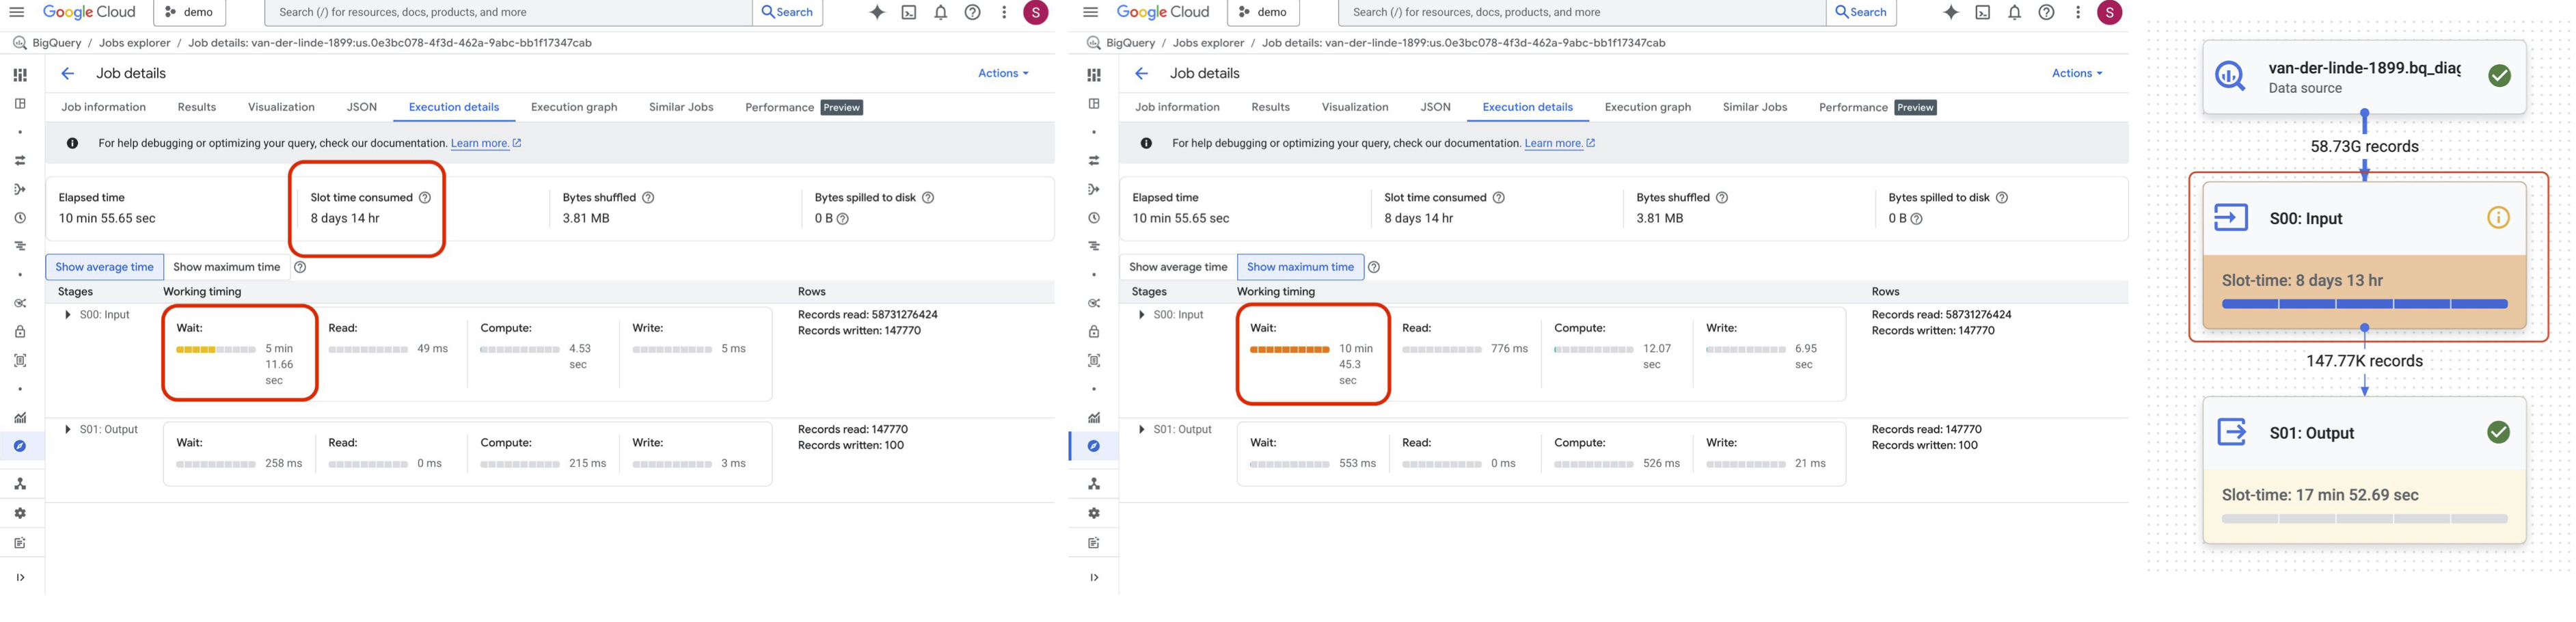

**The Problem:** When your query has many tasks ready to start executing, but BigQuery can't get enough available slots to execute them.

**The Symptom:** High Wait time with a high gap between `Average` and `Maximum Wait time`

**The Solution:**
1. Reduce the data you are processing  
2. Ensure your tables are clustered and/or partitioned
3. Increase the number of available slots

In [ ]:
"""
Simulate Slot Contention.

We run a JavaScript UDF (User Defined Function) that burns CPU cycles (`for` loop).
This forces BigQuery to use maximum slots. If the reservation is too small, you will see high 'Wait Time' for slots.
"""
query_udf = '''
CREATE TEMP FUNCTION HeavyProcess(input STRING)
RETURNS STRING
LANGUAGE js AS """
  var out = "";
  // Inefficient loop to burn CPU
  for(var i=0;i<1000;i++) { out = input + i; }
  return out;
""";
'''

query_main = f"""
SELECT
  REGEXP_REPLACE(cpu_target, r'[^a-zA-Z]', '') as clean_text,
  HeavyProcess(cpu_target) as js_output
FROM
  `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_chaos`
WHERE
  -- Sample 10% so we don't timeout, but enough to spike CPU
  RAND() < 0.1
"""

final_query = query_udf + query_main

# slots_contention_query = client.query(final_query)
# slots_contention_query.result()

**Key Takeaways:**

* When you run a query, BigQuery attempts to break up the work needed by your query into tasks. A task is a single slice of data that is input into and output from a stage. A single slot picks up a task and executes that slice of data for the stage. Ideally, BigQuery slots execute these tasks in parallel to achieve high performance. **Demand for Slots > Supply of Slots**

**Links to Documentation:**

* Get query performance insights: https://docs.cloud.google.com/bigquery/docs/query-insights#slot_contention

### **→** Partition Skew

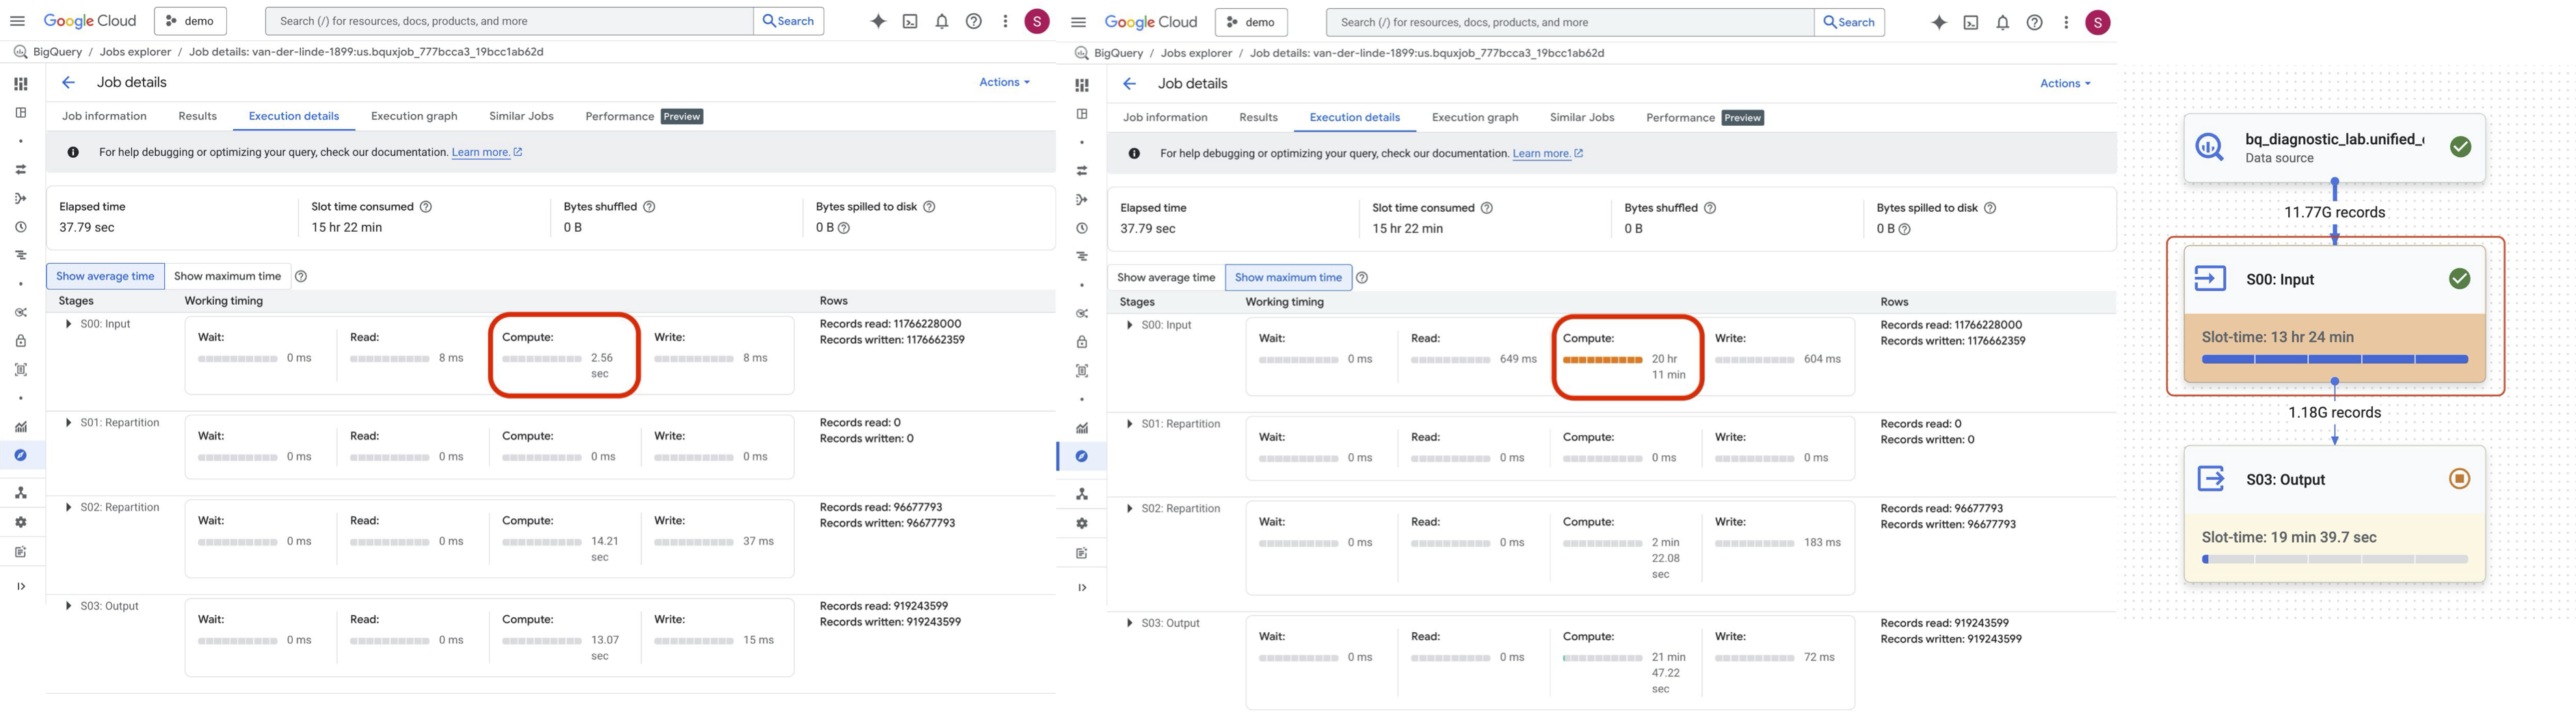

**The Problem:** When you group by a key that has massive "Skew" (e.g., 90% of your data belongs to `user_id = 1` or `status = 'active'`), a single slot gets overloaded with that 90% of data. Other slots finish quickly and sit idle, waiting for the overloaded slot.

**The Symptom:** Identify skew using the Execution Graph by looking for high `Max Wait Time` vs `Avg Wait Time`.

**The Solution:**
 1. Filter you data early
 2. Handle NULL and default values: A common cause of skew is a large number of rows with NULL or empty string values in key columns. If you don't need these rows for analysis, filter them out using a `WHERE` clause before the `JOIN` or `GROUP BY`.
 3. Repartition your data on smaller granularity (for example form monthly to daily
 4. Salt the key (add a random number to break it up)
 5. Use approximate functions: For aggregations on skewed data, consider if an approximate result is acceptable. Functions like `APPROX_COUNT_DISTINCT` are more tolerant of data skew than exact functions like `COUNT(DISTINCT)`

In [ ]:
"""
Analyze Partition Skew.

We group by `skew_id`. Since 99% of rows have `skew_id = 1`, one worker will process 99% of the data while others sit idle.
Look for the 'Max Slot Time' vs 'Avg Slot Time' in the execution graph.
"""
query = f"""
SELECT
  skew_id,
  COUNT(*) as row_count,
  SUM(LENGTH(heavy_payload)) as total_bytes
FROM
  `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_chaos`
GROUP BY
  skew_id
"""

# partition_skew_query = client.query(query)
# partition_skew_query.result()

**Key Takeaways:**

* Diagnosis: If Max Slot Time >> Avg Slot Time, you likely have skew.

**Links to Documentation:**

* Get query performance insights: https://docs.cloud.google.com/bigquery/docs/query-insights#partition_skew

### **→** High Cardinality Join

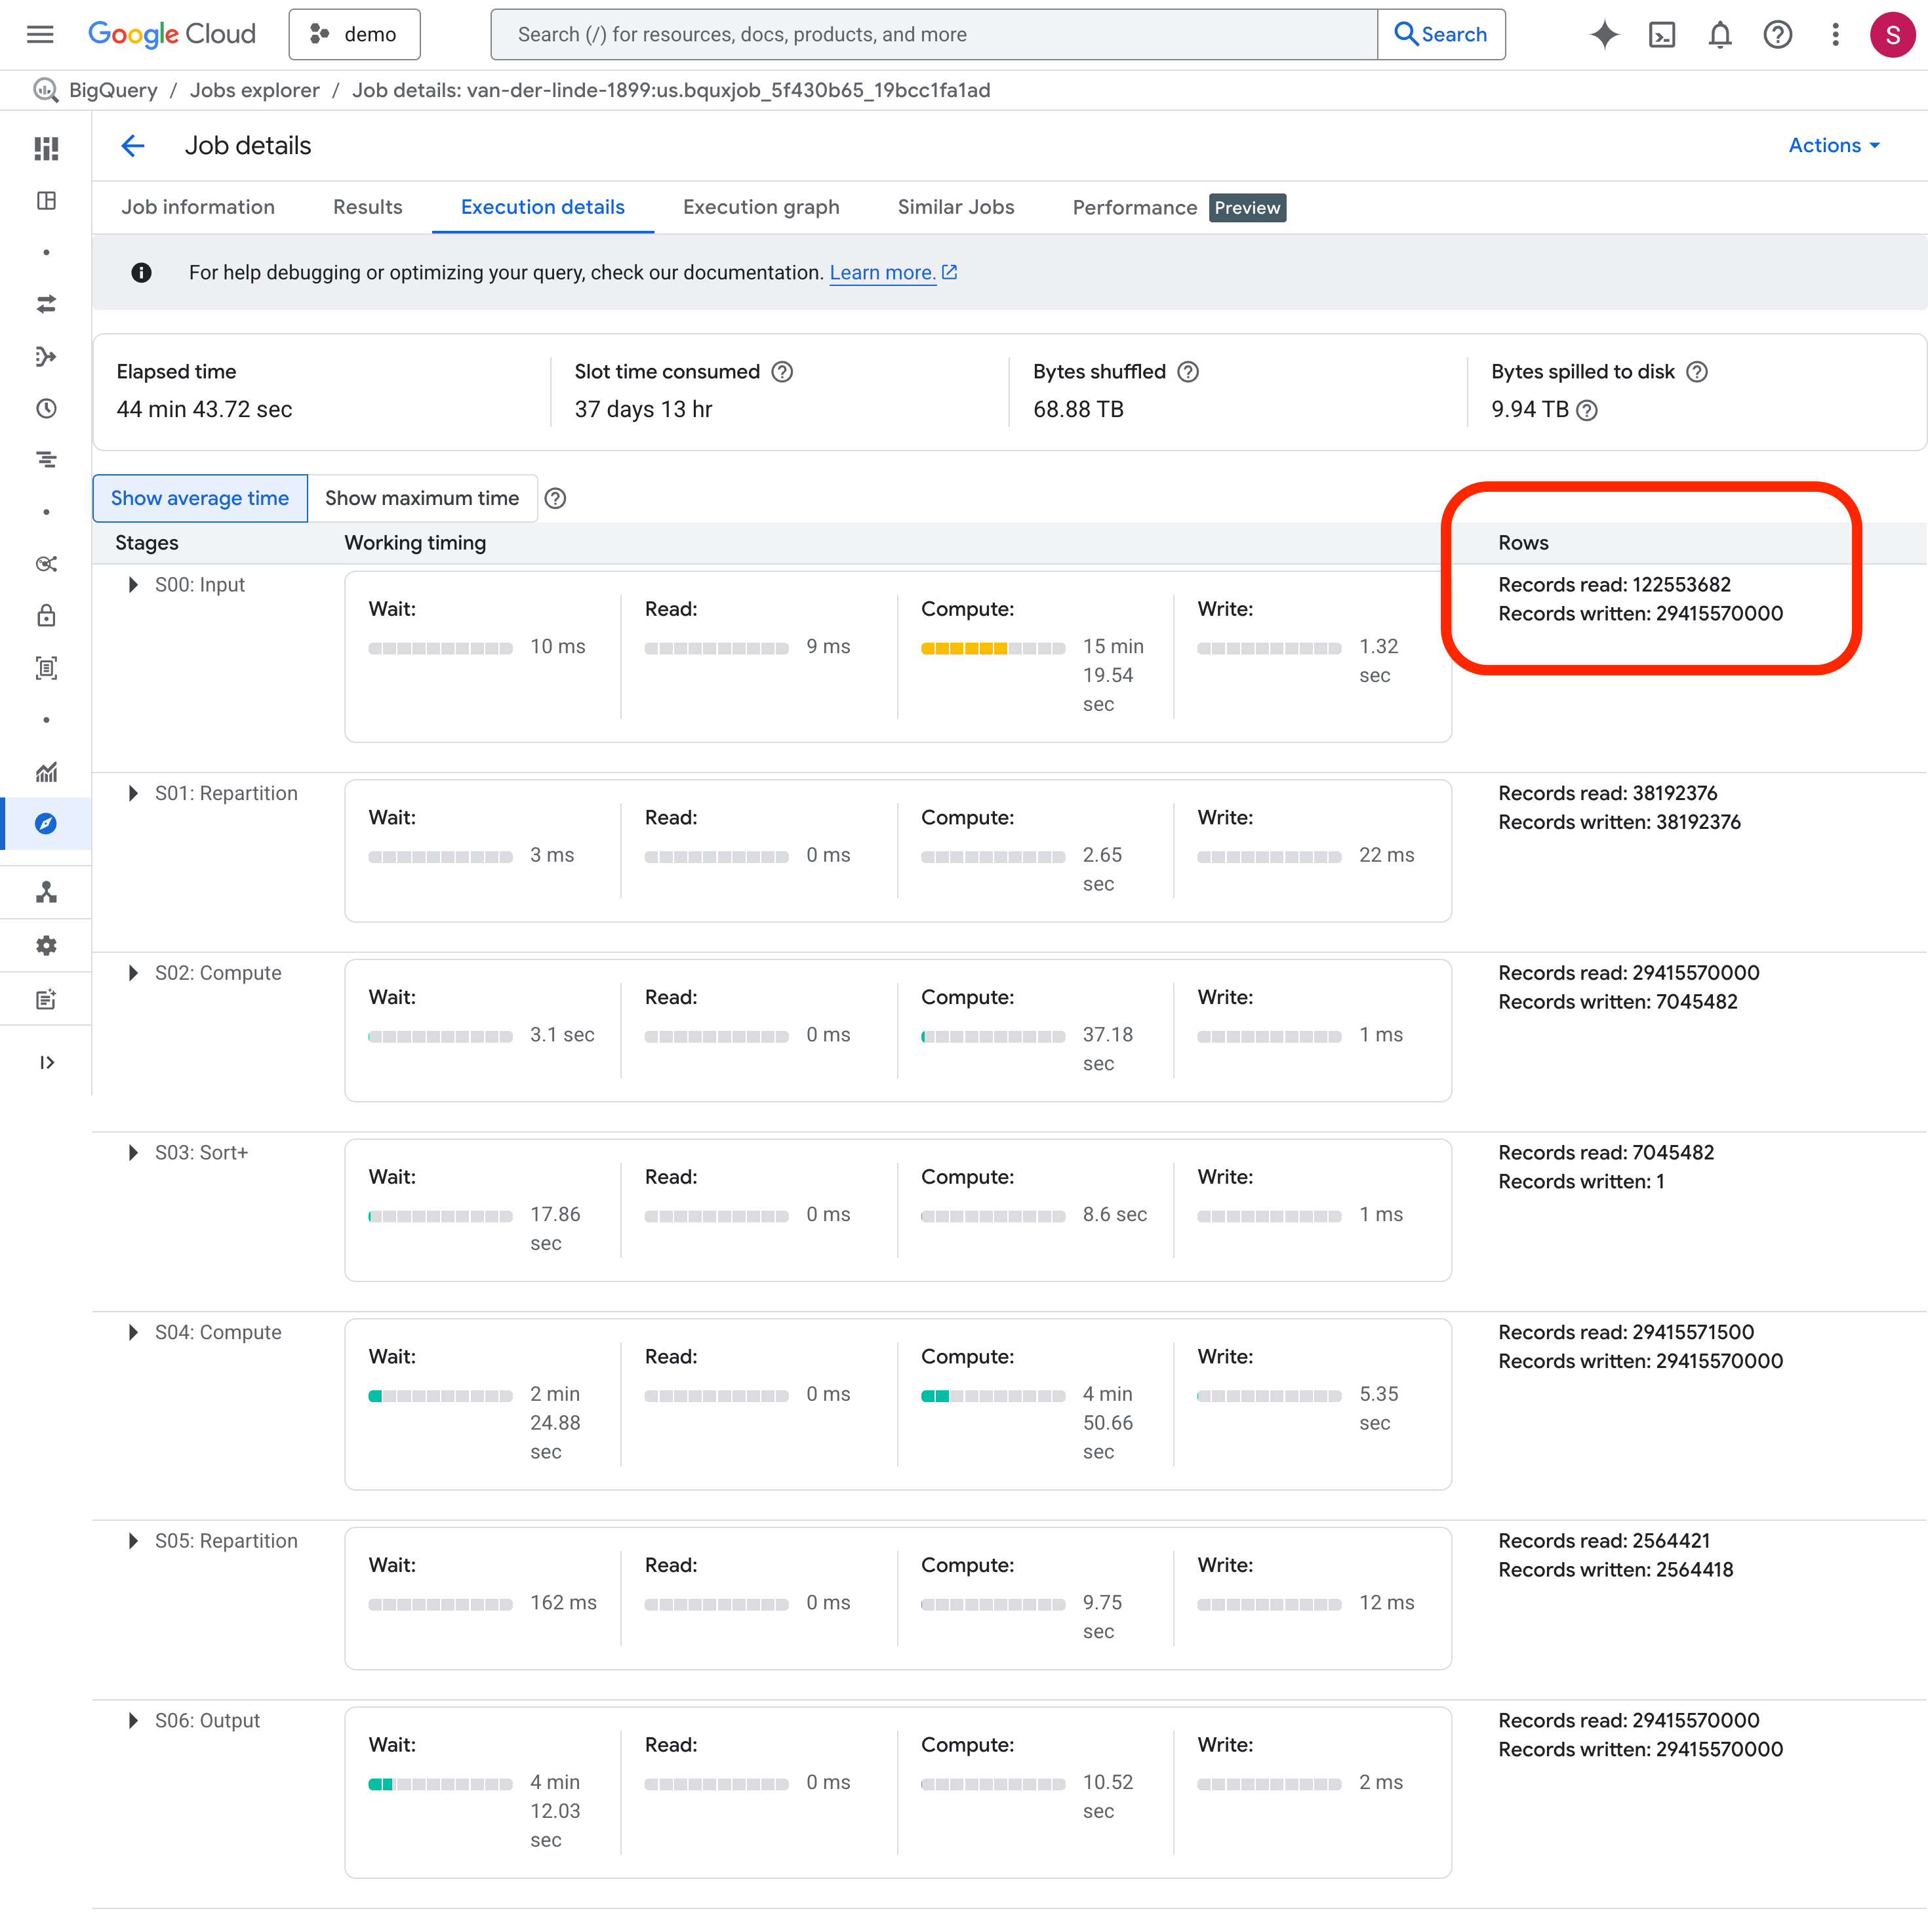

**The Problem:** When a query contains a join with non-unique keys on both sides of the join, the size of the output table can be considerably larger than the size of either of the input tables. This insight indicates that the ratio of output rows to input rows is high and offers information about these row counts.

**The Symptom:** Records write much bigger than Records read

**The Solution:**
1. Avoid using cross joins.
2. If you must use a cross join, try using a GROUP BY clause to pre-aggregate results, or use a window function.
3. **Reduce before join**

In [ ]:
"""
Simulate High Cardinality Join.

We join the Chaos table to itself on a unique key.
Since there are no common keys to aggregate early, BigQuery must shuffle ALL rows. This tests the shuffle throughput limits.
"""
query = f"""
SELECT
  t1.cpu_target,
  t2.cluster_key
FROM
  `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_chaos` t1
JOIN
  `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_chaos` t2
ON
  t1.unique_join_key = t2.unique_join_key
LIMIT 1000
"""

# join_query = client.query(query)
# join_query.result()

**Key Takeaways:**

* Check your join conditions to confirm that the increase in the size of the output table is expected. (Read vs Write)

**Links to Documentation:**

* Get query performance insights: https://docs.cloud.google.com/bigquery/docs/query-insights#high_cardinality_join

### **→** Shuffle Quota

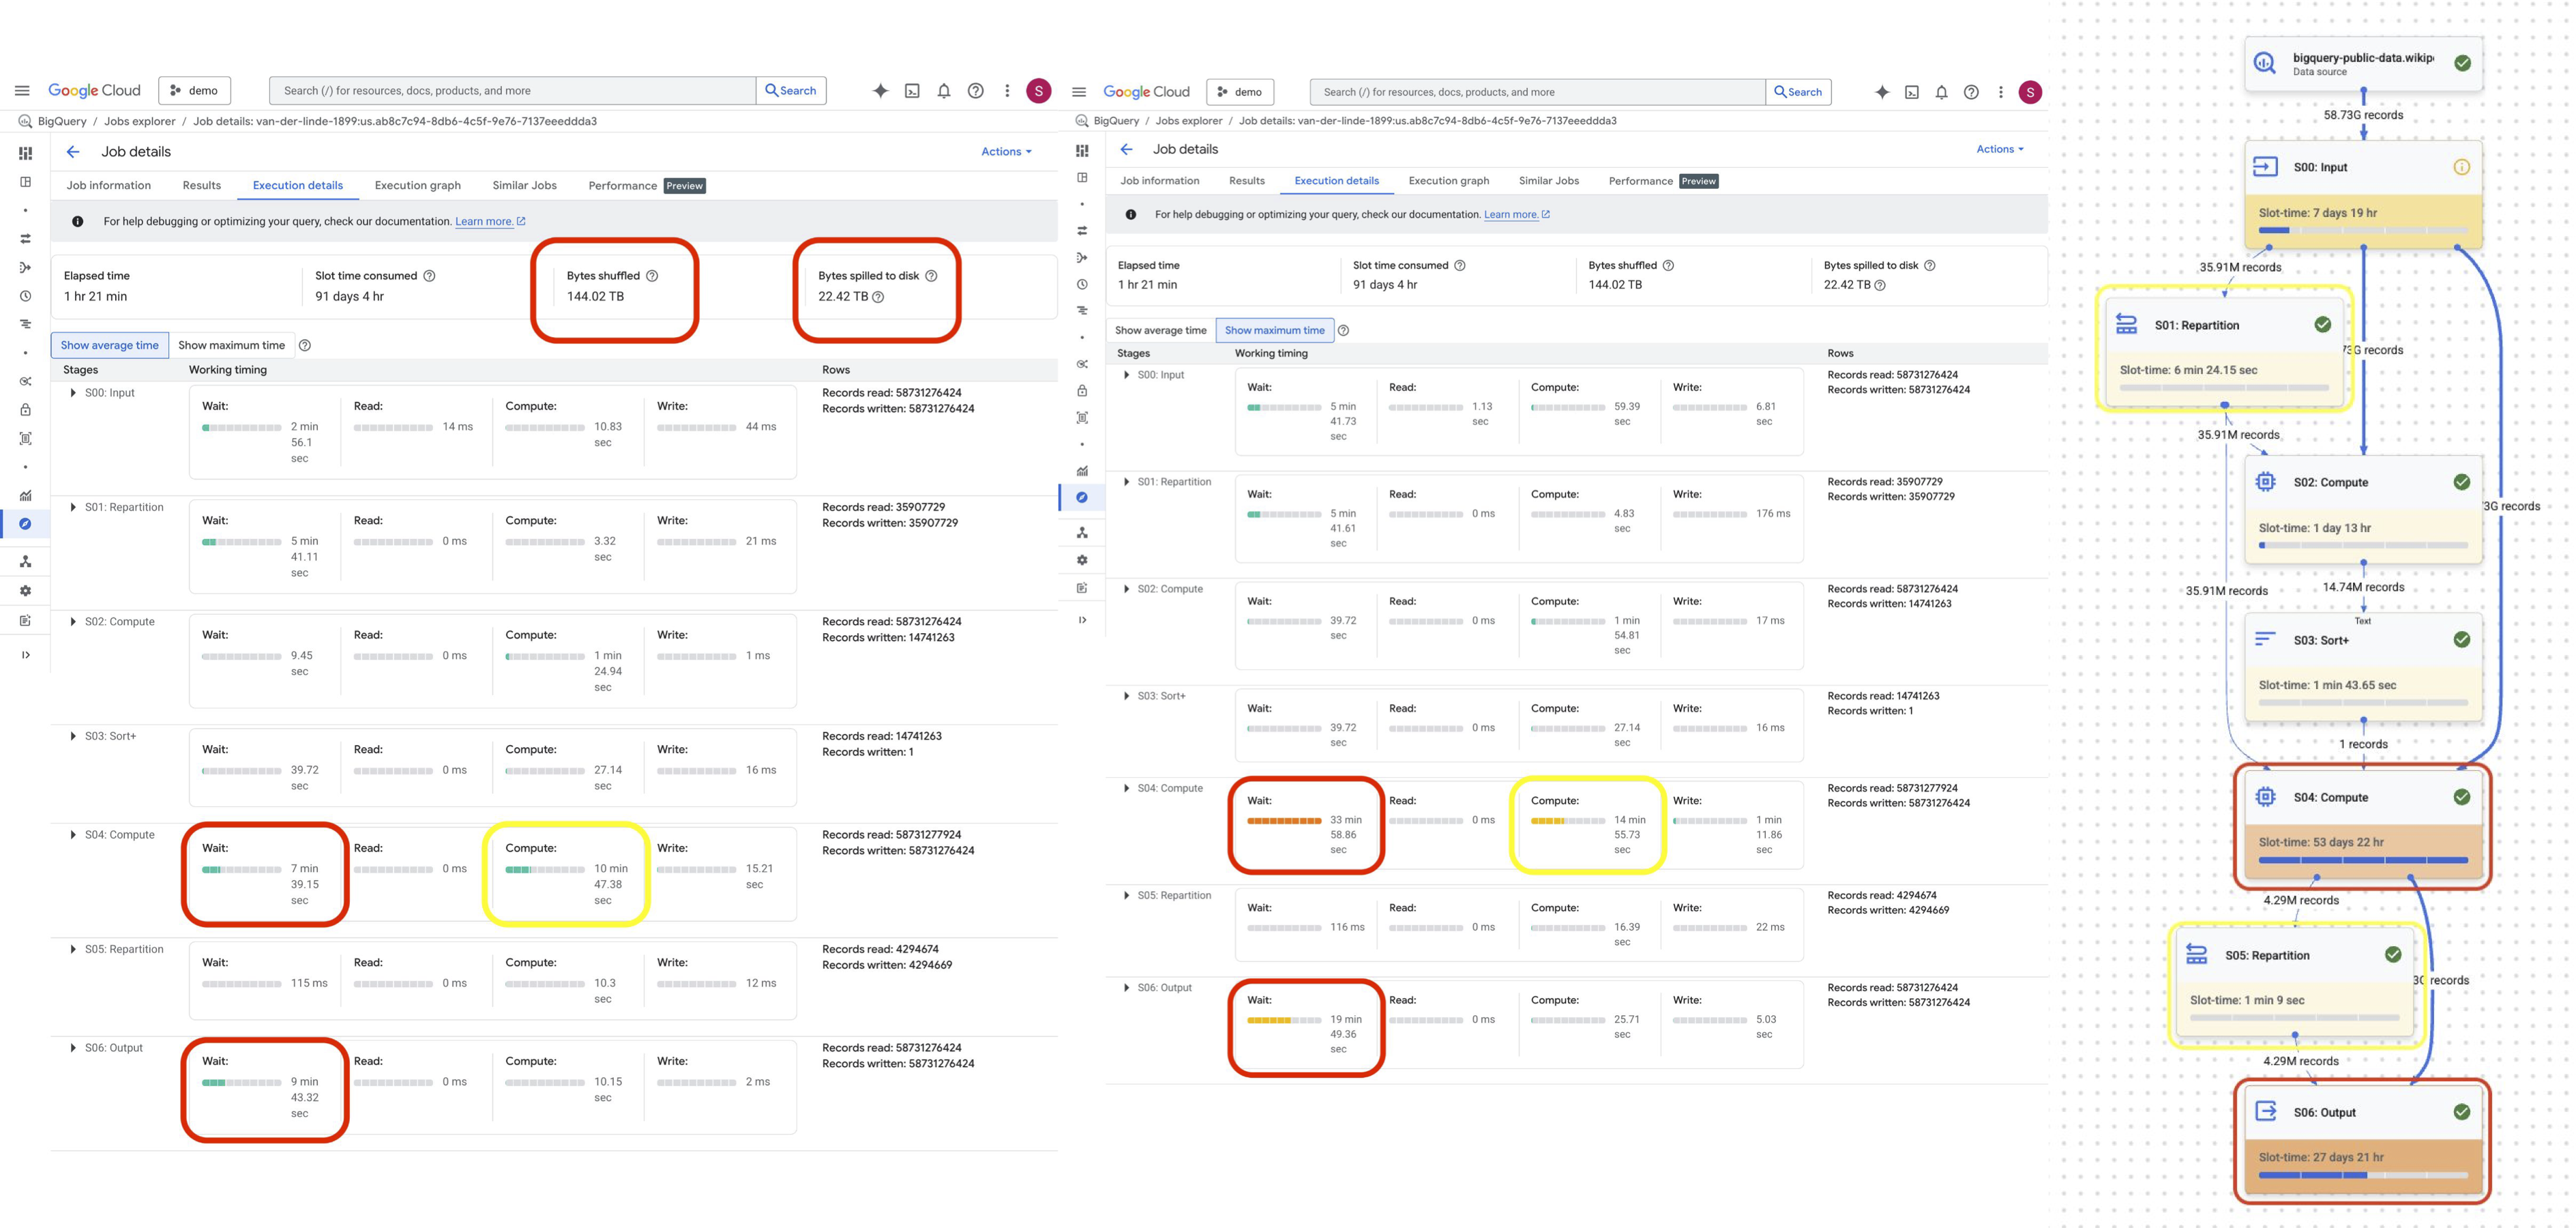

**The Problem:** Insufficient shuffle quota occurs when you have more data that needs to get written to shuffle than you have shuffle capacity. Operations like `JOIN`,`ORDER BY` or `GROUP BY` on massive columns require passing data through a bottleneck. If the data being shuffled exceeds the memory limit, BigQuery spills data to disk, which kills performance.

**The Symptom:** The query has more than one stage and:
1. If you see Long Write Times in an intermediate stage (not the final stage), it means your workers are struggling to upload this temporary data to the Shuffle Tier.
2. **Or** if you see a Repartition stage **and** high Wait Time in the next stage.

**The Solution:**
1. Reduce the amount of data you are processing, specifically in the `JOIN`,`ORDER BY` or `GROUP BY` operations
2. Increase the number of slots

In [ ]:
"""
Exhaust Shuffle Quota.

We attempt to sort a massive amount of data with a heavy payload.
This fills up the allocated shuffle disk/memory. When quota is exceeded, the query may fail or spill to disk (slow).
"""
query = f"""
SELECT
  heavy_payload
FROM
  `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_chaos`
-- Filter slightly to ensure it runs, but keep it heavy
WHERE
  skew_id = 1
ORDER BY
  heavy_payload
LIMIT 10000
"""

# shuffle_query = client.query(query)
# shuffle_query.result()

**Key Takeaways:**

* When you run a query, BigQuery attempts to break up the work needed by your query into tasks. A task is a single slice of data that is input into and output from a stage. A single slot picks up a task and executes that slice of data for the stage. Ideally, BigQuery slots execute these tasks in parallel to achieve high performance.
* Dealing with Shuffle Quota is similar to Slot Contention

**Links to Documentation:**

* Search indexed data: https://docs.cloud.google.com/bigquery/docs/search

---
## **3. Query Optimizations**

### **→** `SELECT *` vs `SELECT Column`
**The Problem:** BigQuery is a columnar store. It stores each column in a separate file. `SELECT *` forces it to open and read every file for that table, incurring maximum cost and I/O overhead.

**The Solution:** Only select the specific columns you need.

In [ ]:
"""
Anti-Pattern: SELECT *.

Selecting all columns reads unnecessary data.
Observe the 'Bytes Scanned' metric compared to selecting only the columns you need.
"""
# Bad: Select *
select_all_query = f"SELECT * FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_basic` LIMIT 100"
select_all = client.query(select_all_query)
select_all.result()

# Good: Select specific
select_col_query = f"SELECT title, views FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_basic` LIMIT 100"
select_col = client.query(select_col_query)
select_col.result()

compare_bq_jobs(select_all=select_all, select_col=select_col)

-----------------------------------------------------------------------------
METRIC               | select_all           | select_col           (Impact)  
-----------------------------------------------------------------------------
Duration             | 0.62s                | 0.76s                +23.6%    
Slot Time            | 2 minutes and 16.73 seconds | 1 minute and 44.65 seconds -23.5%    
Bytes Scanned        | 2.7 TB               | 1.9 TB               -29.8%    
Bytes Shuffled       | 8.4 MB               | 5.5 MB               -34.8%    
Est. Cost            | $16.5948             | $11.6535             -29.8%    
-----------------------------------------------------------------------------


**Key Takeaways:**

* Cost Control: You are billed for bytes read. Selecting 1 column of 10 is ~90% cheaper (depends on file type and size).

**Links to Documentation:**

* Optimize query computation: https://docs.cloud.google.com/bigquery/docs/best-practices-performance-compute#reduce-data-processed

### **→** `ORDER BY` vs `ORDER BY ... LIMIT`
**The Problem:** `ORDER BY` sorts the entire result set. If you have millions of rows, BigQuery must sort all of them, funneling them to a single last stage. This causes "Resources Exceeded" errors.
**The Solution:** If you only want the Top 10, add `LIMIT 10`. BigQuery optimizes this by discarding non-qualifying rows early before the final sort.

In [ ]:
"""
Optimization: ORDER BY with LIMIT.

When sorting, always provide a LIMIT if possible.
This allows BigQuery to keep only the top N rows in memory at each stage, discarding the rest early (Top-K Sort).
"""
q_sort = f"""
SELECT title FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_basic`
ORDER BY views DESC LIMIT 10000
"""
query_sort = client.query(q_sort)
query_sort.result()


q_topn = f"""
SELECT title FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_basic`
ORDER BY views DESC
LIMIT 100
"""
query_topn = client.query(q_topn)
query_topn.result()

compare_bq_jobs(query_sort=query_sort, query_topn=query_topn)

-----------------------------------------------------------------------------
METRIC               | query_sort           | query_topn           (Impact)  
-----------------------------------------------------------------------------
Duration             | 53.82s               | 8.26s                -84.7%    
Slot Time            | 4 hours, 53 minutes and 26.60 seconds | 4 hours, 39 minutes and 45.46 seconds -4.7%     
Bytes Scanned        | 1.9 TB               | 1.9 TB               +0.0%     
Bytes Shuffled       | 16.0 GB              | 159.9 MB             -99.0%    
Est. Cost            | $11.6535             | $11.6535             +0.0%     
-----------------------------------------------------------------------------


**Key Takeaways:**

* **Limit doesn't save costs**, since the whole data is proccessed. Limit affects **only** the last root stage.

* Optimal for:
1. Data Exploration - Sanity Checks
2. Top N Reporting
3. Reduce processing time

**Links to Documentation:**

* Optimize query computation: https://docs.cloud.google.com/bigquery/docs/best-practices-performance-compute#optimize_the_order_by_clause

### **→** `WHERE` Clause Ordering
**The Problem:** While the query optimizer is smart, providing filters in an inefficient order can sometimes lead to suboptimal execution. Expensive filters (like `LIKE '%...%'` or `REGEXP`) should ideally run **after selective filters**.

**The Solution:** Place your most selective filters (e.g., Boolean, Integer, Date) first.


In [ ]:
"""
Optimization: Filter Ordering.

Place the most selective filters (e.g., on Partition Key) FIRST.
Although the optimizer reorders many operations, guiding it with selective filters helps prune data earlier in the pipeline.
"""
query_where = f"""
SELECT count(*)
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_partitioned`
WHERE title LIKE '%Google%'
AND datehour = '2024-01-01 12:00:00'
"""

query_where_ordered = f"""
SELECT count(*)
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_partitioned`
WHERE datehour = '2024-01-01 12:00:00'
AND title LIKE '%Google%'
"""

query_where = client.query(query_where)
query_where.result()

query_where_ordered = client.query(query_where_ordered)
query_where_ordered.result()

compare_bq_jobs(query_where=query_where, query_where_ordered=query_where_ordered)

-----------------------------------------------------------------------------
METRIC               | query_where          | query_where_ordered  (Impact)  
-----------------------------------------------------------------------------
Duration             | 1.02s                | 0.84s                -18.4%    
Slot Time            | 26.16 seconds        | 19.16 seconds        -26.8%    
Bytes Scanned        | 4.5 GB               | 4.5 GB               +0.0%     
Bytes Shuffled       | 189 Bytes            | 189 Bytes            +0.0%     
Est. Cost            | $0.0279              | $0.0279              +0.0%     
-----------------------------------------------------------------------------


**Key Takeaways:**

* Filter Early: Reduce the dataset as much as possible before applying expensive logic.

**Links to Documentation:**

* Optimize query computation: https://docs.cloud.google.com/bigquery/docs/best-practices-performance-compute#use_the_where_clause

### **→** `REGEXP` vs `LIKE`
**The Problem:** functions like `REGEXP` are powerful tools but they initialize a complex state machine for every row. It is computationally expensive (Slot Time) compared to simple string matching.

**The Solution:** If you are just checking if a string contains a substring, use `LIKE`. It is highly optimized and significantly cheaper.

In [ ]:
"""
Optimization: LIKE vs REGEXP.

`REGEXP` is powerful but CPU intensive.
For simple suffix/prefix/existence checks, standard `LIKE` or `STARTS_WITH` is much faster and uses less Slot Time.
"""
query_regex = f"""
SELECT
    COUNT(*) as match_count
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_partitioned`
WHERE DATE(datehour) = '2024-01-01'
AND REGEXP_CONTAINS(title, r'.*Google.*')
"""

query_like = f"""
SELECT
    COUNT(*) as match_count
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_partitioned`
WHERE DATE(datehour) = '2024-01-01'
AND title LIKE '%Google%'
"""

query_regex = client.query(query_regex)
query_regex.result()

query_like = client.query(query_like)
query_like.result()

compare_bq_jobs(query_regex=query_regex, query_like=query_like)

-----------------------------------------------------------------------------
METRIC               | query_regex          | query_like           (Impact)  
-----------------------------------------------------------------------------
Duration             | 1.99s                | 1.07s                -46.1%    
Slot Time            | 53.05 seconds        | 25.82 seconds        -51.3%    
Bytes Scanned        | 4.5 GB               | 4.5 GB               +0.0%     
Bytes Shuffled       | 189 Bytes            | 189 Bytes            +0.0%     
Est. Cost            | $0.0279              | $0.0279              +0.0%     
-----------------------------------------------------------------------------


**Key Takeaways:**

* **Always** prefer a spcialized function for your use case. In our example, only use `REGEXP` when `LIKE` cannot express the logic.

**Links to Documentation:**

* Best practices for functions: https://docs.cloud.google.com/bigquery/docs/best-practices-performance-functions#optimize_string_comparison

### **→** Reduce before `JOIN`
**The Problem:** Joining two raw tables before aggregating them creates massive intermediate datasets. If Table A has 1B rows and Table B has 1B rows, joining them first requires shuffling huge amounts of data.

**The Solution:**
1. Filter before `JOIN`
2. Aggregate before `JOIN` - Only do this if `COUNT(DISTINCT key)` is significantly smaller than `COUNT(*)` (Low Cardinality)

In [ ]:
"""
Optimization: Reduce Before Join.

Aggregate your data (GROUP BY) *before* joining it to a dimension table.
This reduces the number of rows entering the join, minimizing shuffle volume and CPU usage.
"""
dim_table = f"{PROJECT_ID}.{WORKING_DATASET_ID}.wiki_dim"
setup_sql = f"""
CREATE OR REPLACE TABLE `{dim_table}` AS
SELECT DISTINCT wiki, CONCAT('Description for ', wiki) as wiki_desc
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_partitioned`
"""
client.query(setup_sql).result()

q_bad = f"""
SELECT
    d.wiki_desc,
    SUM(f.views) as total_views
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_partitioned` AS f
JOIN `{dim_table}` AS d
ON f.wiki = d.wiki
WHERE DATE(f.datehour) = '2024-01-01' -- Limit to 1 day for speed
GROUP BY d.wiki_desc
"""

q_good = f"""
WITH pre_aggregated AS (
    SELECT
        wiki,
        SUM(views) as total_views
    FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_partitioned`
    WHERE DATE(datehour) = '2024-01-01'
    GROUP BY wiki
)
SELECT
    d.wiki_desc,
    agg.total_views
FROM pre_aggregated agg
JOIN `{dim_table}` AS d
ON agg.wiki = d.wiki
"""

j_bad = client.query(q_bad)
j_bad.result()

j_good = client.query(q_good)
j_good.result()

compare_bq_jobs(j_bad=j_bad, j_good=j_good)

-----------------------------------------------------------------------------
METRIC               | j_bad                | j_good               (Impact)  
-----------------------------------------------------------------------------
Duration             | 1.55s                | 0.66s                -57.7%    
Slot Time            | 33.95 seconds        | 11.28 seconds        -66.8%    
Bytes Scanned        | 3.1 GB               | 3.1 GB               +0.0%     
Bytes Shuffled       | 1.3 MB               | 776.5 kB             -41.6%    
Est. Cost            | $0.0193              | $0.0193              +0.0%     
-----------------------------------------------------------------------------


**Key Takeaways:**

* Reduce Before Join protects you from Data Skew (Slot Contention, Partition Skew and Shuffle Quota)

**Links to Documentation:**

* Optimize query computation: https://docs.cloud.google.com/bigquery/docs/best-practices-performance-compute#reduce_data_before_using_a_join

### **→** `INT64` vs `STRING` Joins
**The Problem:** Joining on `STRING` columns (e.g., "user_123") is slower and more expensive than joining on `INT64` (e.g., 123). Strings take up more bytes (higher bytes scanned) and require character-by-character comparison (higher CPU proccessing time -> slower queries ).

**The Solution:** Use Integer keys for joins whenever possible. If you have string keys, consider hashing them to integers for the join if strict uniqueness isn't compromised.

In [ ]:
# We will use 'title' (high cardinality) as our join key.

tbl_fact_str = f"{PROJECT_ID}.{WORKING_DATASET_ID}.fact_views_str"
tbl_dim_str = f"{PROJECT_ID}.{WORKING_DATASET_ID}.dim_titles_str"
tbl_fact_int = f"{PROJECT_ID}.{WORKING_DATASET_ID}.fact_views_int"
tbl_dim_int = f"{PROJECT_ID}.{WORKING_DATASET_ID}.dim_titles_int"
# Create String Dimension
client.query(f"""
CREATE TABLE IF NOT EXISTS `{tbl_dim_str}` AS
SELECT DISTINCT title, LENGTH(title) as title_len
FROM `{BASELINE_PROJECT_ID}.{BASELINE_DATASET_ID}.{BASELINE_TABLE_ID}`
WHERE DATE(datehour) = '2024-01-01'
""").result()
# Create String Fact
client.query(f"""
CREATE TABLE IF NOT EXISTS`{tbl_fact_str}` AS
SELECT title, views
FROM `{BASELINE_PROJECT_ID}.{BASELINE_DATASET_ID}.{BASELINE_TABLE_ID}`
WHERE DATE(datehour) = '2024-01-01'
""").result()

# Create Integer Dimension
client.query(f"""
CREATE OR REPLACE TABLE `{tbl_dim_int}` AS
SELECT DISTINCT FARM_FINGERPRINT(title) as title_id, LENGTH(title) as title_len
FROM `{BASELINE_PROJECT_ID}.{BASELINE_DATASET_ID}.{BASELINE_TABLE_ID}`
WHERE DATE(datehour) = '2024-01-01'
""").result()
# Create Integer Fact
client.query(f"""
CREATE OR REPLACE TABLE `{tbl_fact_int}` AS
SELECT FARM_FINGERPRINT(title) as title_id, views
FROM `{BASELINE_PROJECT_ID}.{BASELINE_DATASET_ID}.{BASELINE_TABLE_ID}`
WHERE DATE(datehour) = '2024-01-01'
""").result()

print("Integer vs String Tables Created.")

Integer vs String Tables Created.


In [ ]:
"""
Optimization: INT64 vs STRING Joins.

Integer comparisons are much faster for the CPU than String comparisons.
Prefer using Integer keys (or hashed values) for joins on large tables.
"""
query_join_str = f"""
SELECT
    sum(a.views) as total_views,
    avg(b.title_len) as avg_len
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.fact_views_str` a
JOIN `{PROJECT_ID}.{WORKING_DATASET_ID}.dim_titles_str` b
    ON a.title = b.title
"""

query_join_int = f"""
SELECT
    sum(a.views) as total_views,
    avg(b.title_len) as avg_len
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.fact_views_int` a
JOIN `{PROJECT_ID}.{WORKING_DATASET_ID}.dim_titles_int` b
    ON a.title_id = b.title_id
"""

print("Running String Join...")
job_str = client.query(query_join_str)
job_str.result()

print("Running Integer Join...")
job_int = client.query(query_join_int)
job_int.result()

compare_bq_jobs(job_str=job_str, job_int=job_int)

Running String Join...
Running Integer Join...
-----------------------------------------------------------------------------
METRIC               | job_str              | job_int              (Impact)  
-----------------------------------------------------------------------------
Duration             | 2.22s                | 1.30s                -41.7%    
Slot Time            | 6 minutes and 39.90 seconds | 3 minutes and 30.99 seconds -47.2%    
Bytes Scanned        | 5.3 GB               | 2.7 GB               -49.6%    
Bytes Shuffled       | 6.0 GB               | 3.0 GB               -49.7%    
Est. Cost            | $0.0331              | $0.0167              -49.6%    
-----------------------------------------------------------------------------


**Key Takeaways:**

* Storage Cost: `STRING`= 2 logical bytes + the UTF-8 encoded string size vs. `INT64` 8 logical bytes. The string "user_123" takes 10 bytes. The integer 123 takes 8 bytes. Scale: If you have 10 billion rows, that 2-byte difference becomes 20 GB of extra data to read.

* Shuffle Cost: When you join two large tables, BigQuery cannot compare them in place. It must "shuffle" the data, moving rows with the same key to the same worker node. Your query sits idle, waiting for data to move across the network. This doesn't increase your scanned bytes bill, but it consumes more Slot Time and increases latency

* If you must use string keys (like UUIDs) and want better performance, you can create a synthetic `INT64` key using a hashing function like `FARM_FINGERPRINT`

**Links to Documentation:**

* Data types: https://docs.cloud.google.com/bigquery/docs/reference/standard-sql/data-types#data_type_sizes

* Optimize query computation: https://docs.cloud.google.com/bigquery/docs/best-practices-performance-compute#use_int64_data_types_in_joins

* Hash functions: https://docs.cloud.google.com/bigquery/docs/reference/standard-sql/hash_functions#farm_fingerprint

### **→** `JOIN` Largest Table First
**The Problem:** BigQuery employs sophisticated algorithms (like History-Based optimizations and Snowflake joins) to determine the best order to join tables. However, relying solely on the optimizer can sometimes yield suboptimal plans if the heuristics miss the best "driving" table. The optimizer may treat the order you write in your SQL as a preferred path, so arbitrary ordering can lead to inefficiency.

**The Solution:** Manually order your joins in the SQL code. The recommended best practice is to **start with the largest table** (in the FROM clause), followed by the smallest table.

In [ ]:
"""
Optimization: Join Order.

BigQuery generally handles join order well, but explicitly putting the LARGEST table on the LEFT (first) can sometimes guide the optimizer to better broadcast/hash join decisions.
"""
# Large Table: One day of Wikipedia pageviews (~25GB scanned)
large_table_ref = f"{BASELINE_PROJECT_ID}.{BASELINE_DATASET_ID}.{BASELINE_TABLE_ID}"
# Small Table: Country codes ISO lookup (~250 rows, <1MB)
small_table_ref = "bigquery-public-data.utility_us.country_code_iso"

query_small_first = f"""
SELECT
    t1.country_name,
    SUM(t2.views) AS total_views
FROM
    `{small_table_ref}` AS t1
JOIN
    `{large_table_ref}` AS t2
    ON t2.wiki = t1.alpha_2_code
WHERE
    DATE(datehour) >= '2024-01-01'
GROUP BY
    1
"""

query_large_first = f"""
SELECT
    t2.country_name,
    SUM(t1.views) AS total_views
FROM
    `{large_table_ref}` AS t1
JOIN
    `{small_table_ref}` AS t2
    ON t1.wiki = t2.alpha_2_code
WHERE
    DATE(datehour) >= '2024-01-01'
GROUP BY
    1
"""

job_small_first = client.query(query_small_first)
job_large_first = client.query(query_large_first)
job_small_first.result()
job_large_first.result()

compare_bq_jobs(job_small_first=job_small_first, job_large_first=job_large_first)

-----------------------------------------------------------------------------
METRIC               | job_small_first      | job_large_first      (Impact)  
-----------------------------------------------------------------------------
Duration             | 7.98s                | 4.68s                -41.4%    
Slot Time            | 4 hours, 6 minutes and 11.86 seconds | 15 minutes and 11.62 seconds -93.8%    
Bytes Scanned        | 31.0 GB              | 31.0 GB              +0.0%     
Bytes Shuffled       | 7.3 kB               | 7.3 kB               +0.0%     
Est. Cost            | $0.1937              | $0.1937              +0.0%     
-----------------------------------------------------------------------------


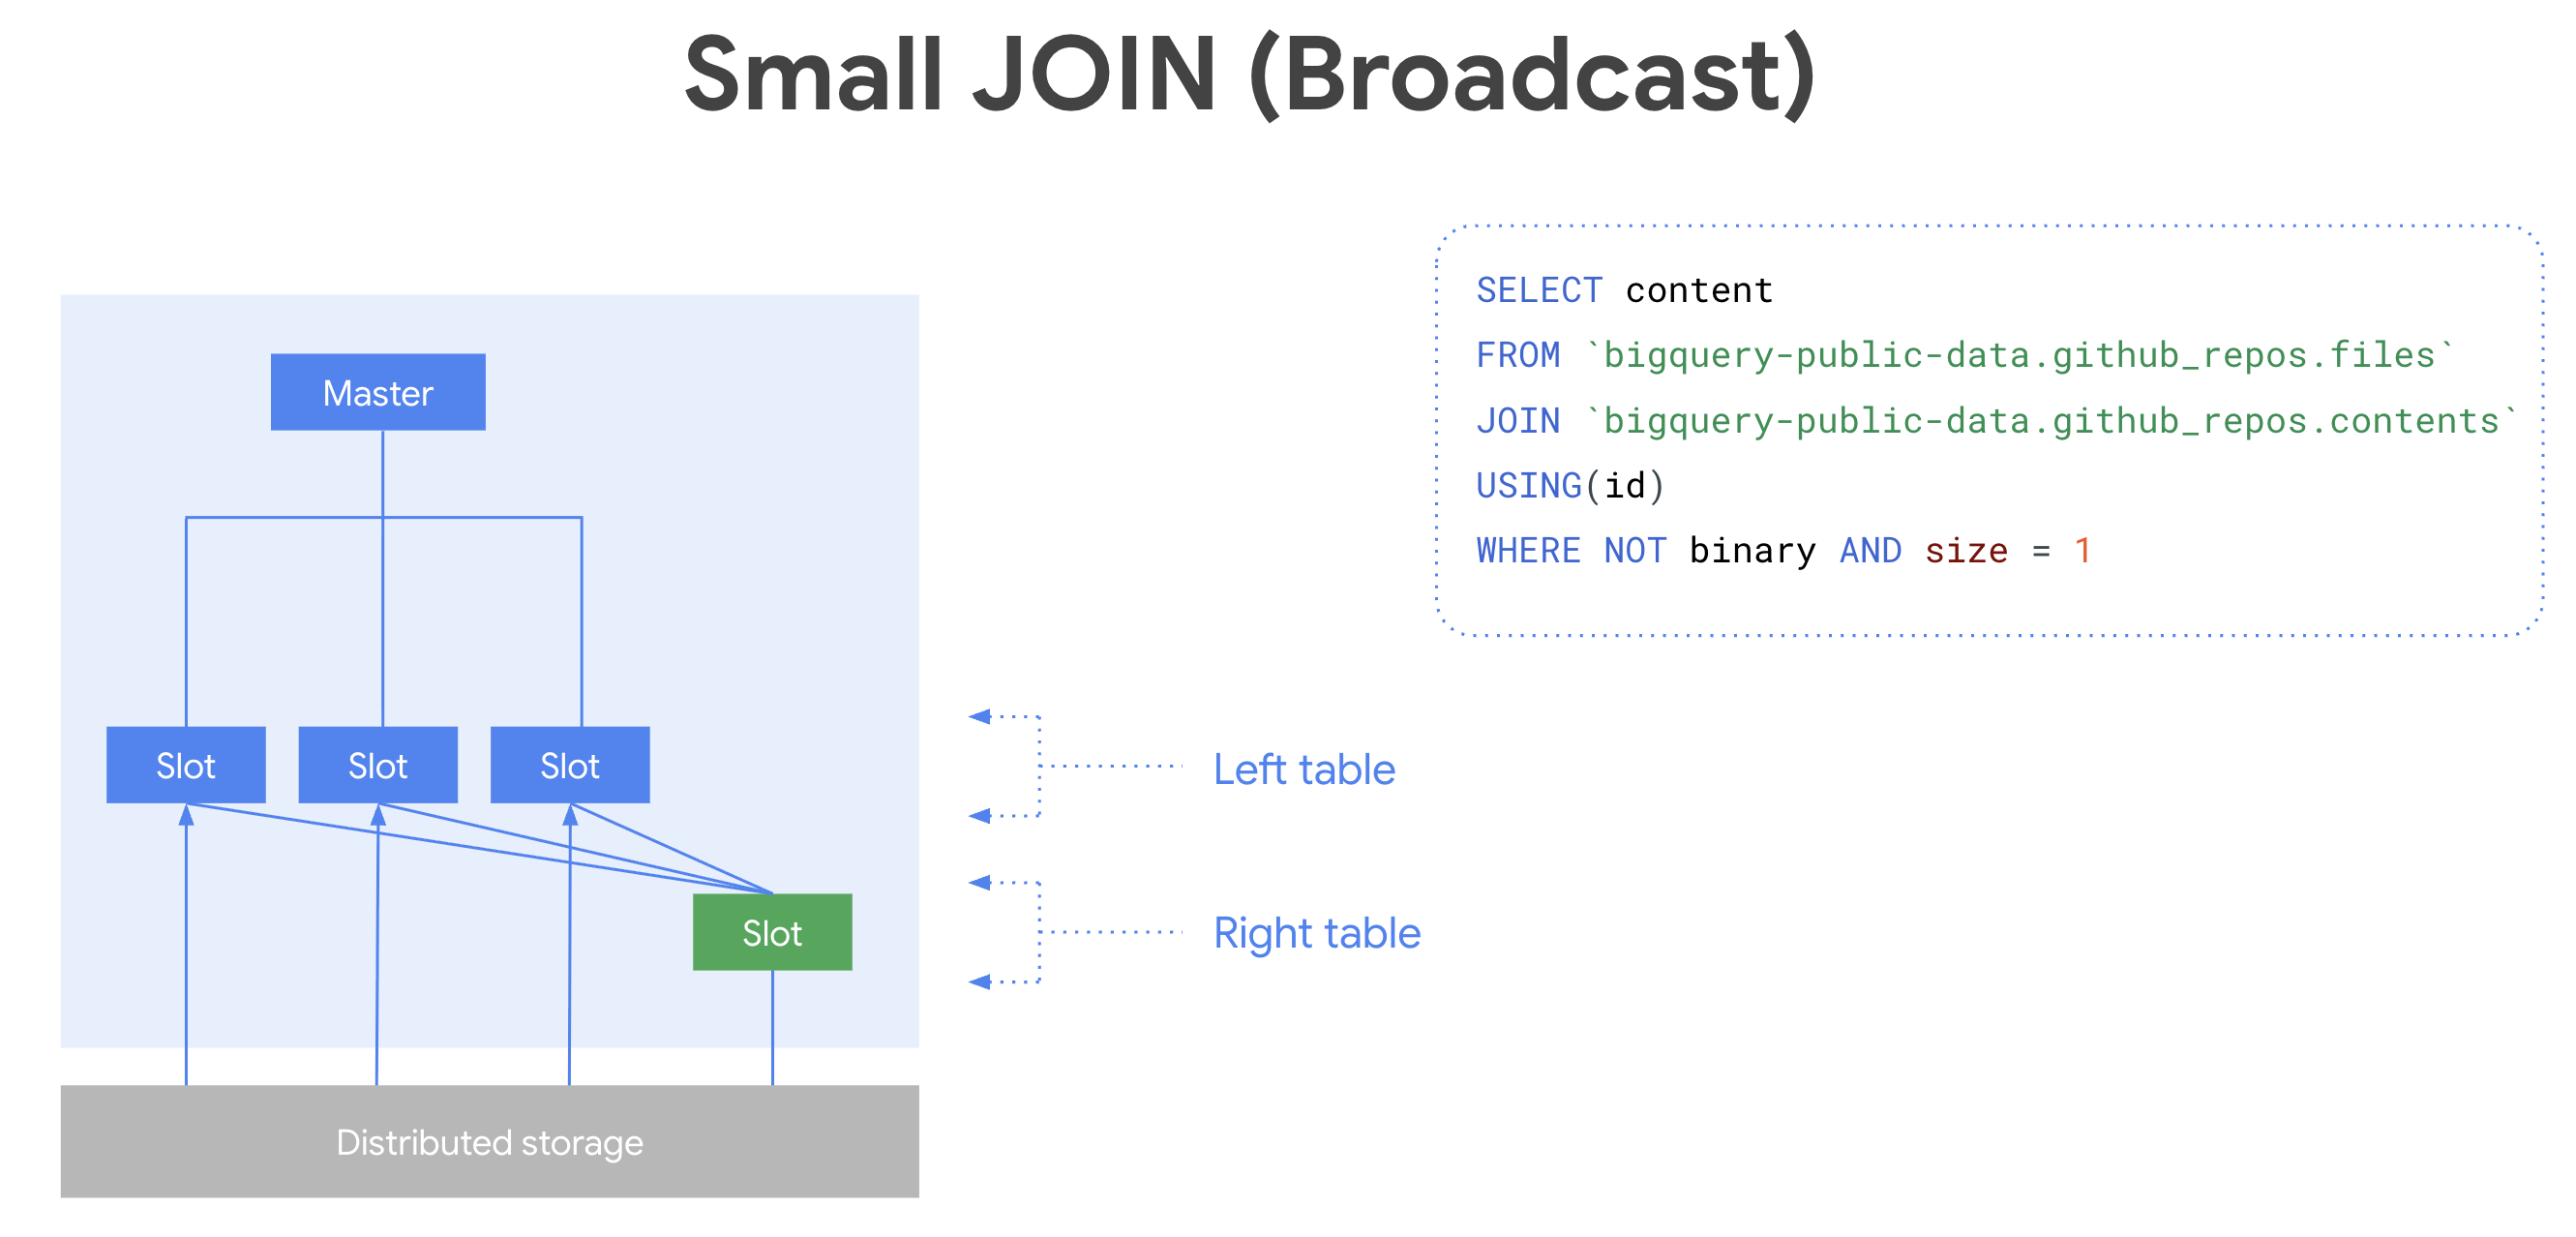

**Key Takeaways:**

* Place the largest table immediately after FROM, following with the smaller table.

**Links to Documentation:**

* Optimize query computation: https://docs.cloud.google.com/bigquery/docs/best-practices-performance-compute#optimize_your_join_patterns


### **→** Self `JOIN`
**The Problem:** Self-joins (joining a table to itself) are commonly used to compare rows, such as finding the difference between "today's" value and "yesterday's" value for the same user. This approach often squares the number of output rows or intermediate processing steps, causing a massive explosion in the number of bytes generated and poor performance.

**The Solution:** Use Window Functions instead of self-joins. Functions like `LAG()`, `LEAD()`, and `RANK()` allow you to access data from preceding or succeeding rows based on a specific ordering, without the heavy overhead of joining the table to itself.

In [ ]:
"""
Create the Chaos Table.

We generate a massive, synthetic dataset designed to break things.
*   **Skew**: 99% of data maps to one key.
*   **Heavy Payload**: Large strings to saturate shuffle.
*   **High Cardinality**: Unique keys to explode joins.
"""
# Setup: Create a Daily Aggregate Table
tbl_daily = f"{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_daily_summary"

sql_setup_daily = f"""
CREATE TABLE IF NOT EXISTS `{tbl_daily}`
AS
SELECT
    DATE(datehour) as day,
    title,
    wiki,
    SUM(views) as total_views
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_chaos`
WHERE DATE(datehour) >= '2024-01-01'
GROUP BY 1, 2, 3
"""

client.query(sql_setup_daily).result()

# --- Query 1: The "Bad" Self-Join ---
# Calculating Day-over-Day change by joining the table to itself
query_self_join = f"""
SELECT
    t1.day,
    t1.title,
    t1.total_views AS current_views,
    t2.total_views AS prev_day_views,
    t1.total_views - t2.total_views AS growth
FROM `{tbl_daily}` t1
LEFT JOIN `{tbl_daily}` t2
    ON t1.title = t2.title
    AND t1.wiki = t2.wiki
    AND t1.day = DATE_ADD(t2.day, INTERVAL 1 DAY)
LIMIT 1000
"""

# --- Query 2: The "Good" Window Function ---
# Achieving the same result with LAG() in a single pass
query_window_func = f"""
SELECT
    day,
    title,
    total_views AS current_views,
    LAG(total_views) OVER (PARTITION BY title, wiki ORDER BY day) AS prev_day_views,
    total_views - LAG(total_views) OVER (PARTITION BY title, wiki ORDER BY day) AS growth
FROM `{tbl_daily}`
LIMIT 1000
"""

job_self_join = client.query(query_self_join)
job_self_join.result()

job_window = client.query(query_window_func)
job_window.result()

compare_bq_jobs(job_self_join=job_self_join, job_window=job_window)

-----------------------------------------------------------------------------
METRIC               | job_self_join        | job_window           (Impact)  
-----------------------------------------------------------------------------
Duration             | 90.91s               | 27.20s               -70.1%    
Slot Time            | 2 days and 26.33 seconds | 15 hours, 12 minutes and 10.71 seconds -68.3%    
Bytes Scanned        | 842.9 GB             | 842.9 GB             +0.0%     
Bytes Shuffled       | 3.0 TB               | 1.1 TB               -61.7%    
Est. Cost            | $5.2679              | $5.2679              +0.0%     
-----------------------------------------------------------------------------


**Key Takeaways:**

* Self-joins can drastically increase the number of intermediate rows; window functions process the data in a single pass, leading to better performance and less slot time

**Links to Documentation:**

* Optimize query computation: https://docs.cloud.google.com/bigquery/docs/best-practices-performance-compute#avoid_self_joins

### **→** `COUNT(DISTINCT)` vs `APPROX_COUNT_DISTINCT`
**The Problem:** Calculating an exact `COUNT(DISTINCT)` on a massive dataset (e.g., Unique Visitors) requires BigQuery to track every single unique value in memory to ensure no duplicates. This consumes massive memory and shuffling resources.

**The Solution:** SUse `APPROX_COUNT_DISTINCT`. It uses the `HyperLogLog++` algorithm to estimate the count with negligible error (typically <1%) but **significantly less memory usage**.

In [ ]:
"""
Optimization: APPROX_COUNT_DISTINCT.

Exact `COUNT(DISTINCT)` is expensive as it requires tracking every unique value.
`APPROX_COUNT_DISTINCT` uses statistical algorithms (HLL++) to give a very accurate count with a fraction of the resource usage.
"""
count_exact_query = f"SELECT COUNT(DISTINCT datehour) FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_partitioned`"
count_exact = client.query(count_exact_query)
count_exact.result()

count_approx_query = f"SELECT APPROX_COUNT_DISTINCT(datehour) FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_partitioned`"
count_approx = client.query(count_approx_query)
count_approx.result()

compare_bq_jobs(count_exact=count_exact, count_approx=count_approx)

-----------------------------------------------------------------------------
METRIC               | count_exact          | count_approx         (Impact)  
-----------------------------------------------------------------------------
Duration             | 4.88s                | 3.59s                -26.4%    
Slot Time            | 2 hours, 55 minutes and 30.77 seconds | 2 hours, 17 minutes and 8.46 seconds -21.9%    
Bytes Scanned        | 469.9 GB             | 469.9 GB             +0.0%     
Bytes Shuffled       | 2.3 MB               | 963.5 kB             -57.7%    
Est. Cost            | $2.9366              | $2.9366              +0.0%     
-----------------------------------------------------------------------------


**Key Takeaways:**

* Appropriate for large data streams for which linear memory usage is impractical, as well as for data that is already approximate.

**Links to Documentation:**

* Approximate aggregate functions: https://docs.cloud.google.com/bigquery/docs/reference/standard-sql/approximate_aggregate_functions

### **→** `JSON String` vs `Native JSON`
**The Problem:** Storing `JSON` as a standard `STRING` blob is inefficient. To read one field, BigQuery must read the whole string and parse it at query time (CPU intensive)

**The Solution:** Use the native `JSON` data type. BigQuery optimizes the storage of this type, allowing it to extract specific fields without parsing the entire object tree.

In [ ]:
"""
Feature: Native JSON Type.

Store semi-structured data as `JSON` type, not `STRING`.
BigQuery optimizes JSON binary storage, allowing for efficient field access without parsing the entire text blob.
"""
tbl_json_str = f"{PROJECT_ID}.{WORKING_DATASET_ID}.json_string"
tbl_json_native = f"{PROJECT_ID}.{WORKING_DATASET_ID}.json_native"

json_str_table = f"""
CREATE TABLE IF NOT EXISTS `{tbl_json_str}`
AS
SELECT
    datehour,
    -- Pack the columns into a STRUCT, then convert to JSON String
    TO_JSON_STRING(STRUCT(title, wiki, views)) as payload_str
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_partitioned`
WHERE DATE(datehour) = '2024-01-01'
"""

json_native_table = f"""
CREATE TABLE IF NOT EXISTS `{tbl_json_native}`
AS
SELECT
    datehour,
    -- Create a Native JSON object
    SAFE.PARSE_JSON(TO_JSON_STRING(STRUCT(title, wiki, views))) as payload_json
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.pageviews_partitioned`
WHERE DATE(datehour) = '2024-01-01'
"""

client.query(json_str_table).result()
client.query(json_native_table).result()

In [ ]:
query_json_string = f"""
SELECT DISTINCT JSON_VALUE(payload_str, '$.section')
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.json_string`
"""

query_json_native = f"""
SELECT DISTINCT JSON_VALUE(payload_json, '$.section')
FROM `{PROJECT_ID}.{WORKING_DATASET_ID}.calls_native`
"""

query_json_string = client.query(query_json_string)
query_json_string.result()

query_json_native = client.query(query_json_native)
query_json_native.result()

compare_bq_jobs(query_json_string=query_json_string, query_json_native=query_json_native)

-----------------------------------------------------------------------------
METRIC               | query_json_string    | query_json_native    (Impact)  
-----------------------------------------------------------------------------
Duration             | 1.60s                | 0.52s                -67.9%    
Slot Time            | 5 minutes and 39.98 seconds | 43.75 seconds        -87.1%    
Bytes Scanned        | 8.4 GB               | 0 Bytes              -100.0%   
Bytes Shuffled       | 251 Bytes            | 251 Bytes            +0.0%     
Est. Cost            | $0.0526              | $0.0000              -100.0%   
-----------------------------------------------------------------------------


**Key Takeaways:**

* Use Case: Schema on Read

* Optimize Performance: Optimized binary storage reduces parsing overhead.

* Optimize Costs: BigQuery creates under the hood Virtual Columns meanning you often only pay to read the fields you request.

* User Friendly: Supports simple dot notation (data.id) instead of complex functions.

**Links to Documentation:**

* Unlocking the power of semi-structured data with the JSON Type in BigQuery: https://cloud.google.com/blog/products/databases/how-bigquery-powers-semi-structured-data-storage?e=48754805

* Working with JSON data in GoogleSQL: https://docs.cloud.google.com/bigquery/docs/json-data

### **→** Advance Runtime
**The Problem:** Standard BigQuery execution involves overheads like decoding data from storage before processing and distributing even small queries across a shuffle layer. For high-performance analytical workloads, these steps can add unnecessary latency and prevent the engine from utilizing modern CPU capabilities fully.

**The Solution:** Enable the Advanced Runtime. This is a set of performance enhancements that includes:

* **Enhanced Vectorization:** Uses Single Instruction, Multiple Data (SIMD) instructions to process data in blocks aligned with CPU cache size. It also evaluates filters directly on encoded data (Capacitor format) and simplifies complex logic via expression folding.

* **Short Query Optimizations:** Dynamically identifies small queries and runs them in a single stage, bypassing the distributed shuffle layer to drastically reduce latency.

In [ ]:
"""
Enable Advanced Runtime.

We explicitly set the `query_runtime` to 'advanced'.
This enables optimizations like vectorization and short-query acceleration, which are particularly effective for high-concurrency, low-latency workloads.
"""
# Add the capability if not enabled (should be enabled automatically)
# ALTER PROJECT PROJECT_NAME
# SET OPTIONS (
#   `region-LOCATION.query_runtime` = 'advanced'
# );

"\nEnable Advanced Runtime.\n\nWe explicitly set the `query_runtime` to 'advanced'.\nThis enables optimizations like vectorization and short-query acceleration, which are particularly effective for high-concurrency, low-latency workloads.\n"

**Key Takeaways:**

* Automatic Acceleration: Optimizes CPU usage and execution stages without code changes.

* Latency Reduction: Particularly effective for Short Queries by skipping the shuffle step.

**Links to Documentation:**

* Use the BigQuery advanced runtime: https://docs.cloud.google.com/bigquery/docs/advanced-runtime

### **→** History-Based Optimizations
**The Problem:** The BigQuery query optimizer typically relies on heuristics and estimated statistics (like table cardinality) to generate an execution plan. However, these estimates can sometimes be inaccurate, especially for complex queries with multiple joins or aggregations, leading to suboptimal plans (e.g., inefficient join order or insufficient parallelism).

**The Solution:** Allow the query optimizer to use actual execution statistics **from past runs** of the same or similar queries. Instead of guessing, BigQuery "learns" from previous executions to adjust the plan for future runs—optimizing join order and slots allocation based on real-world data.

In [ ]:
# Add the capability if not enabled (should be enabled automatically)
# ALTER PROJECT PROJECT_NAME
# SET OPTIONS (
#   `region-LOCATION.default_query_optimizer_options` = 'adaptive=on'
# );

# Estimate impact of history-based optimizations
query_hbo = f"""
  WITH
    jobs AS (
      SELECT
        *,
        query_info.query_hashes.normalized_literals AS query_hash,
        TIMESTAMP_DIFF(end_time, start_time, MILLISECOND) AS elapsed_ms,
        IFNULL(
          ARRAY_LENGTH(JSON_QUERY_ARRAY(query_info.optimization_details.optimizations)) > 0,
          FALSE)
          AS has_history_based_optimization,
      FROM region-US.INFORMATION_SCHEMA.JOBS_BY_PROJECT
      WHERE EXTRACT(DATE FROM creation_time) > DATE_SUB(CURRENT_DATE(), INTERVAL 30 DAY)
    ),
    most_recent_jobs_without_history_based_optimizations AS (
      SELECT *
      FROM jobs
      WHERE NOT has_history_based_optimization
      QUALIFY ROW_NUMBER() OVER (PARTITION BY query_hash ORDER BY end_time DESC) = 1
    )
  SELECT
    job.job_id,
    100 * SAFE_DIVIDE(
      original_job.elapsed_ms - job.elapsed_ms,
      original_job.elapsed_ms) AS percent_execution_time_saved,
    job.elapsed_ms AS new_elapsed_ms,
    original_job.elapsed_ms AS original_elapsed_ms,
  FROM jobs AS job
  INNER JOIN most_recent_jobs_without_history_based_optimizations AS original_job
    USING (query_hash)
  WHERE
    job.has_history_based_optimization
    AND original_job.end_time < job.start_time
  ORDER BY percent_execution_time_saved DESC
  LIMIT 10;
"""

df = client.query(query_hbo).to_dataframe()
display(df)

job_id  \
0           72585585-1a0d-47a8-b5c4-3f9f2374e2ec   
1                   bquxjob_57f1291e_19bf77bfcb2   
2           65cbdd1a-8aec-4314-90b2-38c0380dc6a0   
3           dc017688-07ed-434a-984f-37948af93292   
4  script_job_30e74ea1a62e9eac204ee2d1be2f2bff_1   
5           992abfd5-3e78-4e78-a397-76f5a7371b5b   
6                   bquxjob_37871f3b_19bcd942a67   
7           34e3f3f5-fbdb-4179-aed6-a88865771d5e   
8           86ffbacd-10ae-4b1f-92b4-e496ef173448   
9           e2f1a219-c457-4e30-a05d-0881c3af8c71   

   percent_execution_time_saved  new_elapsed_ms  original_elapsed_ms  
0                     33.197556             656                  982  
1                     28.884222          648162               911418  
2                     18.327616           27856                34107  
3                     14.751286             497                  583  
4                     -5.625000             845                  800  
5                     -6.019417             546                  515  
6                     -6.958509           30419                28440  
7                    -20.279718         1096251               911418  
8                    -21.791126           45014                36960  
9                    -25.290438            1402                 1119

**Key Takeaways:**

* Self-Learning: The optimizer automatically refines execution plans over repeated runs of similar queries.

* No need to do anything, History Based Optimizations is enabled automatically

* Use the query above to estimate the impact of history-based optimizations

**Links to Documentation:**

* Use history-based optimizations: https://docs.cloud.google.com/bigquery/docs/history-based-optimizations

---
## **4. Cleanup**

In [ ]:
"""
Enable BI Engine.

We create a BI Engine Reservation of 1 GB.
We explicitly set our Materialized View (`mv_monthly_views`) as a `preferred_table` to ensure it gets loaded into RAM.
"""
# 1. Delete the Dataset and all Tables
print(f"Deleting dataset {dataset_id} and all contents...")
try:
    client.delete_dataset(dataset_id, delete_contents=True, not_found_ok=True)
    print(f"Dataset {dataset_id} deleted.")
except Exception as e:
    print(f"Error deleting dataset: {e}")

# 2. Delete the Slot Assignment & Reservation
# Note: We must delete the assignment first, then the reservation.
reservation_name = "academy-lab-reservation"
assignment_name = "academy-assignment"

print(f"Deleting Slot Assignment: {assignment_name}...")
try:
    client.query(f"DROP ASSIGNMENT IF EXISTS `{PROJECT_ID}.region-{REGION}.{reservation_name}.{assignment_name}`").result()
    print(f"Assignment deleted.")
except Exception as e:
    print(f"Error deleting assignment: {e}")

print(f"Deleting Slot Reservation: {reservation_name}...")
try:
    client.query(f"DROP RESERVATION IF EXISTS `{PROJECT_ID}.region-{REGION}.{reservation_name}`").result()
    print(f"Reservation deleted.")
except Exception as e:
    print(f"Error deleting reservation: {e}")

# 3. Reset BI Engine Capacity to 0
# We don't "delete" the config, we just set size to 0 to stop billing.
print(f"Resetting BI Engine Capacity to 0 GB...")
try:
    client.query(f"ALTER BI_CAPACITY `{PROJECT_ID}.region-{REGION}.default` SET OPTIONS(size_gb = 0)").result()
    print(f"BI Engine capacity disabled.")
except Exception as e:
    print(f"Error resetting BI Engine: {e}")

# 4. Re-enable Query Cache
try:
    job_config = bigquery.QueryJobConfig(use_query_cache=True)
    client.default_query_job_config = job_config
except Exception as e:
    print(f"Error re-enabling Query Cache: {e}")
print("Query Cache Re-Enabled")
